<a href="https://colab.research.google.com/github/joeldmott/inventory_project/blob/main/inventory_restocking_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#importing packages to read in data from Kaggle host site
import json
import os
from pathlib import Path
from google.colab import userdata

# api key for importing Kaggle and downloading the datasets
os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

# api key for the json object below
api_key = userdata.get('API_KEY')

# using pathlib Path
kaggle_path = Path('/root/.kaggle')
os.makedirs(kaggle_path, exist_ok=True)

# opening file and dumps python dict to json object
with open (kaggle_path/'kaggle.json', 'w') as handl:
    json.dump(api_key,handl)

os.chmod(kaggle_path/'kaggle.json', 600)

In [2]:
import kaggle
! kaggle datasets download joelmott/liquor-inventory-dataset

Dataset URL: https://www.kaggle.com/datasets/joelmott/liquor-inventory-dataset
License(s): MIT
liquor-inventory-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
!unzip /content/liquor-inventory-dataset.zip

Archive:  /content/liquor-inventory-dataset.zip
replace Iowa_Liquor_Sales_2017_thru_2023.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
df = pd.read_csv('/content/Iowa_Liquor_Sales_2017_thru_2023.csv')
df.head()

,Date,Store Number,Store Name,City,Category Name,Vendor Number,Vendor Name,Bottles Sold
0,01/03/2017,5230,POINT LIQUOR & TOBACCO,NaN,CANADIAN WHISKIES,260.0,DIAGEO AMERICAS,3
1,01/03/2017,4482,INDY 66 WEST #929 / INDIANOLA,NaN,AMERICAN VODKAS,434.0,LUXCO INC,6
2,01/03/2017,5359,FAREWAY STORES # 168/ PEOSTA,PEOSTA,AMERICAN VODKAS,434.0,LUXCO INC,12
3,01/03/2017,5242,KUM & GO #502 / IOWA CITY,NaN,AMERICAN VODKAS,260.0,DIAGEO AMERICAS,1
4,01/03/2017,4482,INDY 66 WEST #929 / INDIANOLA,NaN,COCKTAILS/RTD,395.0,PROXIMO,6


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17468378 entries, 0 to 17468377
Data columns (total 8 columns):
 #   Column         Dtype  
---  ------         -----  
 0   Date           object 
 1   Store Number   int64  
 2   Store Name     object 
 3   City           object 
 4   Category Name  object 
 5   Vendor Number  float64
 6   Vendor Name    object 
 7   Bottles Sold   int64  
dtypes: float64(1), int64(2), object(5)
memory usage: 1.0+ GB


In [6]:
#What's the date range?
df['Date'] = pd.to_datetime(df['Date'])
df['Date'].min(), df['Date'].max()

(Timestamp('2017-01-03 00:00:00'), Timestamp('2023-12-30 00:00:00'))

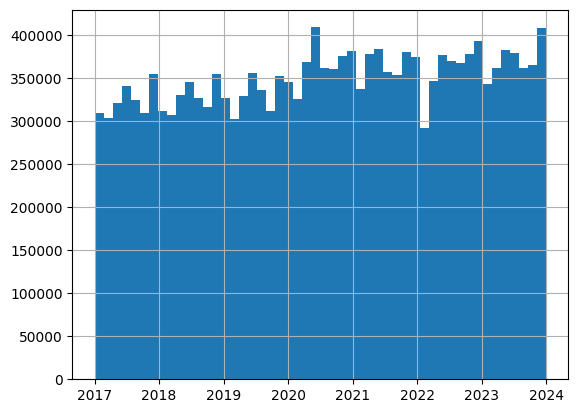

In [7]:
df['Date'].hist(bins=50);

With our time-series data initially explored, let's examine the amount of stores we have.

In [8]:
#How many stores?
unique_stores = df['Store Number'].unique()
len(unique_stores)

2636

In [9]:
#How many with more than 100 orders in here?
store_value_counts = df['Store Number'].value_counts()
hundred_order_stores = pd.DataFrame(store_value_counts)
hundred_order_stores = hundred_order_stores[hundred_order_stores['count'] >= 100]
len(hundred_order_stores)

2540

In [10]:
#How many with more than 1000 orders in here?
store_value_counts = df['Store Number'].value_counts()
thousand_order_stores = pd.DataFrame(store_value_counts)
thousand_order_stores = thousand_order_stores[thousand_order_stores['count'] >= 1000]
len(thousand_order_stores)

2013

That's a good amount of stores with a decent amount of rows to examine. We may wind up looking at the top ten or top 100 stores only depending on how the project goes.

Let's also look at vendors; while stores represent a variable that we may use to *subdivide* the dataset, vendors will remain an independent variable. As a categorical variable, they may balloon out to an overwhelming number of one-hot encoded variables, so we'll alomost certainly need to find a way to limit these.

In [11]:
#How many vendors total?
len(df['Vendor Name'].unique())

436

In [12]:
#How many with more than 100 orders in here?
vendor_value_counts = df['Vendor Name'].value_counts()
hundred_order_vendors = pd.DataFrame(vendor_value_counts)
hundred_order_vendors = hundred_order_vendors[hundred_order_vendors['count'] >= 100]
len(hundred_order_vendors)

234

In [13]:
#How many with more than 1000 orders in here?
thousand_order_vendors = pd.DataFrame(vendor_value_counts)
thousand_order_vendors = thousand_order_vendors[thousand_order_vendors['count'] >= 1000]
len(thousand_order_vendors)

131

131 vendors combined with the liqour categories and a few more continuous columns is probably still going to be too many to model without a problematic amount of noise and/or sparsity in our data. We may consider adding a limitation here to each store along the way. In other words, when we run a model on an individual store, we'll only include vendors that serviced that store with >= 1,000 orders.

This is especially important when we consider that this dataset covers an entire *state* with urban, suburban, and rural stores that all move different volumes of inventory; the vendors used will almost certainly vary from one store to the next.

Before we start examining stores in more detail, we need to take care of a few other things in our broader DataFrame. Specifically, we need to drop unnecessary columns and contend with what appear to be a few NaNs.

Let's first examine columns so we can see which to drop. I appreciate how the data has store, location, and item names and numbers, but for our purposes, we can drop a number of these redundancies.

Ultimately, if our goal is to predict when and how much to reorder, we can eliminate everything except date, store number, category, and bottles sold, but for now we'll still keep sales info since it's easy to include as a continuous column and we'll keep vendor names in case we want to come back and do more extensive modeling later.

In [14]:
nan_rows = df[df.isna().any(axis=1)]
len(nan_rows)

61953

In [15]:
len(nan_rows) / len(df)

0.0035465799972956846

NaN's only make up 0.36% of our data, so we can afford to drop them without sarcificing much data.

In [16]:
trimmed_df = df.dropna(axis=0)
trimmed_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17406425 entries, 2 to 17468377
Data columns (total 8 columns):
 #   Column         Dtype         
---  ------         -----         
 0   Date           datetime64[ns]
 1   Store Number   int64         
 2   Store Name     object        
 3   City           object        
 4   Category Name  object        
 5   Vendor Number  float64       
 6   Vendor Name    object        
 7   Bottles Sold   int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 1.2+ GB


Now we can examine the categorical columns more carefully. We'll use the 'Store Number' column later on in order to subdivide the trimmed_df into stores, so let's begin with the 'Category Name' column.

In [17]:
len(trimmed_df['Category Name'].value_counts())

52

In [18]:
print(trimmed_df['Category Name'].value_counts().to_string())

Category Name
AMERICAN VODKAS                         2630640
CANADIAN WHISKIES                       1667195
STRAIGHT BOURBON WHISKIES               1196067
WHISKEY LIQUEUR                          931441
AMERICAN FLAVORED VODKA                  845411
SPICED RUM                               785948
BLENDED WHISKIES                         707707
100% AGAVE TEQUILA                       587622
AMERICAN SCHNAPPS                        562490
IMPORTED VODKAS                          528288
COCKTAILS/RTD                            513808
AMERICAN BRANDIES                        496911
TENNESSEE WHISKIES                       483711
AMERICAN CORDIALS & LIQUEURS             423666
FLAVORED RUM                             416151
IMPORTED CORDIALS & LIQUEURS             399789
WHITE RUM                                379079
MIXTO TEQUILA                            377151
CREAM LIQUEURS                           352825
IMPORTED BRANDIES                        340450
IMPORTED FLAVORED VODKA   

That's too many to include all of them. Instead, we'll carefully consolidate these into more generalized categories. On one hand, we need to narrow these down for clarity and modeling purposes. On the other hand, we don't want to eliminate too many categories, especially those with a larger value count.

For example, instead of just consolidating everything containing the string 'VODKA' to a general 'VODKA' category, we can at least distinguish between 'VODKA' and a new category called 'FLAVORED VODKA'. We can also do something like divide the whiskey categories into three new ones: 'BOURBON', 'SCOTCH', and 'OTHER WHISKEY'.

In [19]:
#I can use the str.contains method for some categories that are easier
# to generalize. Let's do those first:
trimmed_df.loc[trimmed_df['Category Name'].str.contains('BOURBON'), 'Category Name'] = 'BOURBON'
trimmed_df.loc[trimmed_df['Category Name'].str.contains('RYE'), 'Category Name'] = 'BLENDED AND OTHER WHISKIES'
trimmed_df.loc[trimmed_df['Category Name'].str.contains('TEQUILA'), 'Category Name'] = 'TEQUILA'
trimmed_df.loc[trimmed_df['Category Name'].str.contains('GIN'), 'Category Name'] = 'GIN'
trimmed_df.loc[trimmed_df['Category Name'].str.contains('RUM'), 'Category Name'] = 'RUM'
trimmed_df.loc[trimmed_df['Category Name'].str.contains('BRANDIES'), 'Category Name'] = 'BRANDY'
trimmed_df.loc[trimmed_df['Category Name'].str.contains('SCHNAPPS'), 'Category Name'] = 'SCHNAPPS'
trimmed_df.loc[trimmed_df['Category Name'].str.contains('AMARETTO'), 'Category Name'] = 'LIQUEUR'
trimmed_df.loc[trimmed_df['Category Name'].str.contains('LIQUEUR'), 'Category Name'] = 'LIQUEUR'
trimmed_df.loc[trimmed_df['Category Name'].str.contains('CREME DE'), 'Category Name'] = 'LIQUEUR'
trimmed_df.loc[trimmed_df['Category Name'].str.contains('NEUTRAL GRAIN SPIRITS'), 'Category Name'] = 'NEUTRAL GRAIN SPIRITS'
trimmed_df.loc[trimmed_df['Category Name'].str.contains('COCKTAILS'), 'Category Name'] = 'RTD COCKTAILS'

In [20]:
#Now we'll make more specific recategorizations:

#Whiskies
trimmed_df.loc[trimmed_df['Category Name'] == 'SINGLE MALT SCOTCH', 'Category Name'] = 'SCOTCH WHISKIES'
trimmed_df.loc[trimmed_df['Category Name'] == 'BLENDED WHISKIES', 'Category Name'] = 'BLENDED AND OTHER WHISKIES'
trimmed_df.loc[trimmed_df['Category Name'] == 'IMPORTED WHISKIES', 'Category Name'] = 'BLENDED AND OTHER WHISKIES'
trimmed_df.loc[trimmed_df['Category Name'] == 'AMERICAN WHISKIES', 'Category Name'] = 'BLENDED AND OTHER WHISKIES'
trimmed_df.loc[trimmed_df['Category Name'] == 'STRAIGHT RYE WHISKIES', 'Category Name'] = 'BLENDED AND OTHER WHISKIES'
trimmed_df.loc[trimmed_df['Category Name'] == 'CORN WHISKIES', 'Category Name'] = 'BLENDED AND OTHER WHISKIES'

#Vodka

trimmed_df.loc[trimmed_df['Category Name'] == 'IMPORTED VODKAS', 'Category Name'] = 'VODKA'
trimmed_df.loc[trimmed_df['Category Name'] == 'AMERICAN VODKAS', 'Category Name'] = 'VODKA'
trimmed_df.loc[trimmed_df['Category Name'] == 'AMERICAN FLAVORED VODKA', 'Category Name'] = 'VODKA FLAVORED'
trimmed_df.loc[trimmed_df['Category Name'] == 'IMPORTED FLAVORED VODKA', 'Category Name'] = 'VODKA FLAVORED'

#other liqueurs
trimmed_df.loc[trimmed_df['Category Name'] == 'TRIPLE SEC','Category Name'] = 'LIQUEUR'

In [21]:
#vague and unhelpful categories to drop
trimmed_df = trimmed_df.drop(trimmed_df[trimmed_df['Category Name'] == 'AMERICAN DISTILLED SPIRITS SPECIALTY'].index)
trimmed_df = trimmed_df.drop(trimmed_df[trimmed_df['Category Name'] == 'IMPORTED DISTILLED SPIRITS SPECIALTY'].index)
trimmed_df = trimmed_df.drop(trimmed_df[trimmed_df['Category Name'] == 'SPECIAL ORDER ITEMS'].index)
trimmed_df = trimmed_df.drop(trimmed_df[trimmed_df['Category Name'] == 'DECANTERS & SPECIALTY PACKAGES'].index)
trimmed_df = trimmed_df.drop(trimmed_df[trimmed_df['Category Name'] == 'TEMPORARY & SPECIALTY PACKAGES'].index)
trimmed_df = trimmed_df.drop(trimmed_df[trimmed_df['Category Name'] == 'DELISTED / SPECIAL ORDER ITEMS'].index)
trimmed_df = trimmed_df.drop(trimmed_df[trimmed_df['Category Name'] == 'HOLIDAY VAP'].index)

#getting rid of obscure categories as trade-off for improved model performance
counts = trimmed_df['Category Name'].value_counts()
trimmed_df = trimmed_df[~trimmed_df['Category Name'].isin(counts[counts < 1000].index)]

In [22]:
print('Amount of Revised Liquor Categories:', len(trimmed_df['Category Name'].value_counts()))
print("---------------------------------------")
print(trimmed_df['Category Name'].value_counts().to_string())

Amount of Revised Liquor Categories: 18
---------------------------------------
Category Name
VODKA                         3158928
LIQUEUR                       2265635
RUM                           1729685
CANADIAN WHISKIES             1667195
BOURBON                       1256693
VODKA FLAVORED                1152431
TEQUILA                        964773
BLENDED AND OTHER WHISKIES     853114
BRANDY                         837361
SCHNAPPS                       824816
RTD COCKTAILS                  513808
GIN                            507723
TENNESSEE WHISKIES             483711
SCOTCH WHISKIES                395029
IRISH WHISKIES                 216543
NEUTRAL GRAIN SPIRITS          153032
MEZCAL                          13443
IOWA DISTILLERIES                2398


In [23]:
trimmed_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16996318 entries, 2 to 17468377
Data columns (total 8 columns):
 #   Column         Dtype         
---  ------         -----         
 0   Date           datetime64[ns]
 1   Store Number   int64         
 2   Store Name     object        
 3   City           object        
 4   Category Name  object        
 5   Vendor Number  float64       
 6   Vendor Name    object        
 7   Bottles Sold   int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 1.1+ GB


## moving from the main dataset to individual stores

With that larger-scale data-cleaning process finished, let's start looking toward breaking this data down by store:

In [24]:
#What do, say, the top ten stores look like in terms of sales?
store_counts = trimmed_df['Store Number'].value_counts()
store_counts[0:9]

Store Number
2633    132822
4829    122611
2572    102168
2190     93608
2603     89811
2647     85394
2670     82937
3773     78971
2515     76898
Name: count, dtype: int64

In [25]:
#It turns out that store number '2633' is a Hy-Vee in Des Moines.
# We'll isolate this store and save it for further EDA later.
hy_vee_des_moines = trimmed_df[trimmed_df['Store Number'] == 2633]
#The second-busiest is Central City Liqour, also in Des Moines.
ccl_des_moines = trimmed_df[trimmed_df['Store Number'] == 4829]
#The third-busiest is a Hy Vee Wine & Spirits in Iowa City.
hy_vee_cedar_falls = trimmed_df[trimmed_df['Store Number'] == 2572]

In [26]:
hy_vee_des_moines.info()

<class 'pandas.core.frame.DataFrame'>
Index: 132822 entries, 140 to 17459211
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Date           132822 non-null  datetime64[ns]
 1   Store Number   132822 non-null  int64         
 2   Store Name     132822 non-null  object        
 3   City           132822 non-null  object        
 4   Category Name  132822 non-null  object        
 5   Vendor Number  132822 non-null  float64       
 6   Vendor Name    132822 non-null  object        
 7   Bottles Sold   132822 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 9.1+ MB


Let's delve into the single busiest store and see how its liquor sales dates are distributed.

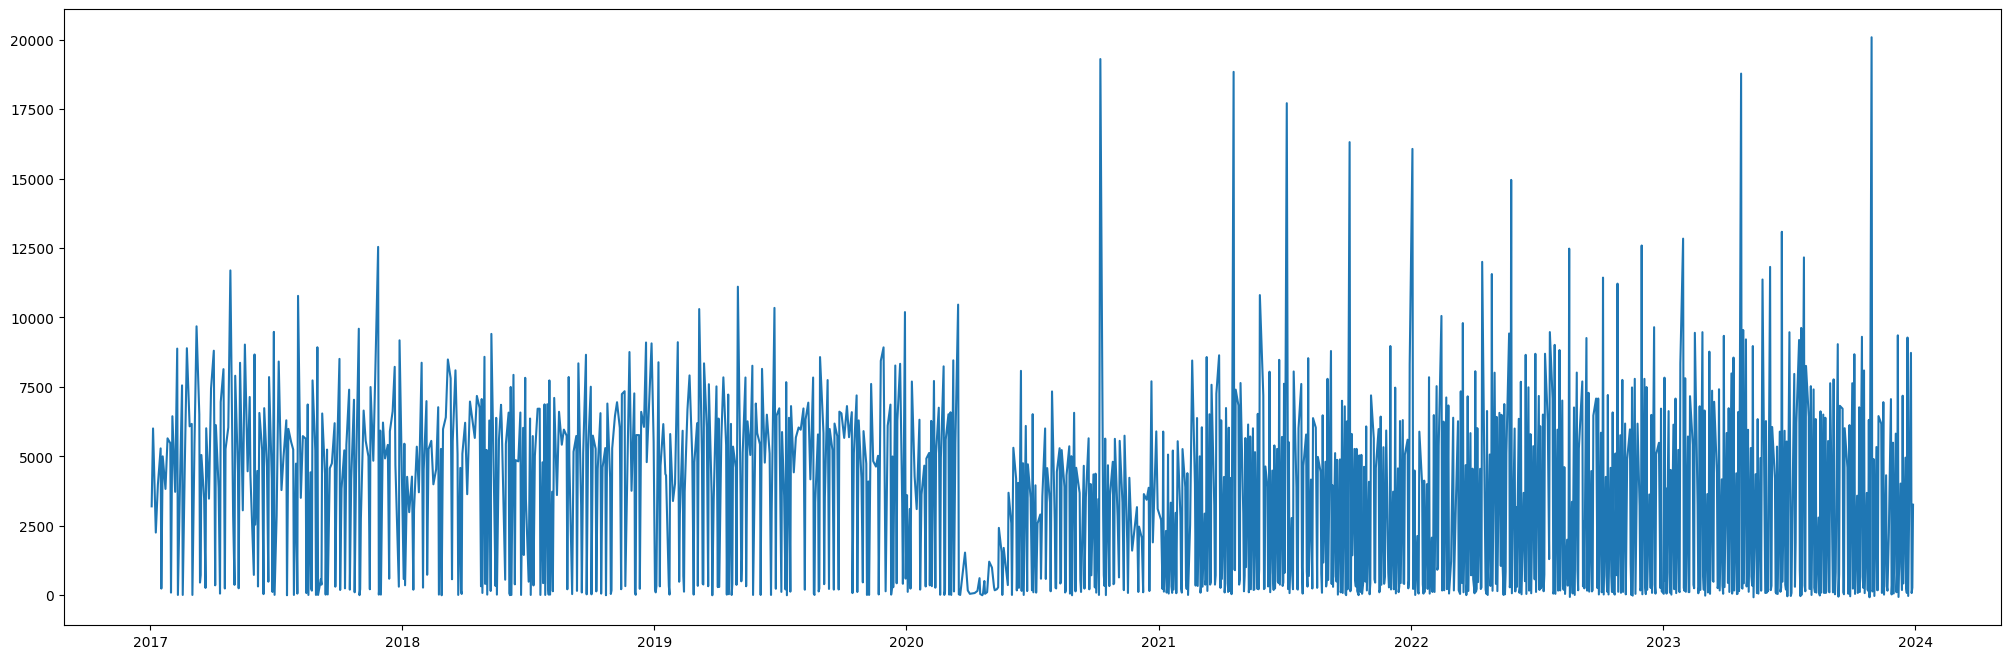

In [27]:
hy_vee_bottles_sold = hy_vee_des_moines.groupby('Date').sum()['Bottles Sold']
fig, ax = plt.subplots(figsize=(25, 8))
ax.plot(hy_vee_bottles_sold);

With the exception of the steep drop at the onset of the pandemic, we can see some semblance of peaks & valleys that suggest some seasonality in the data, so we'll almost certainly have to take that into account when modeling. Before we start a time-series split and running an augmented Dickey-Fuller test and ACF/PACF plots, we have a little more EDA to do here at the store-level.

In [28]:
len(hy_vee_des_moines['Vendor Name'].unique())

211

In [29]:
hy_vee_des_moines['Vendor Name'].value_counts()

Vendor Name
DIAGEO AMERICAS                   22804
JIM BEAM BRANDS                   16033
LUXCO INC                         11584
SAZERAC COMPANY  INC               8758
BACARDI USA INC                    8142
                                  ...  
S&B FARMS DISTILLERY                  1
WOODY CREEK DISTILLERS LLC            1
KOVAL DISTILLERY                      1
STILLWORKS LLC                        1
OLD LOUISVILLE WHISKEY CO. LLC        1
Name: count, Length: 211, dtype: int64

In [30]:
hvdm_vendor_counts = hy_vee_des_moines['Vendor Name'].value_counts()
hvdm__1000_order_vendors = pd.DataFrame(hvdm_vendor_counts)
hvdm__1000_order_vendors = hvdm__1000_order_vendors[hvdm__1000_order_vendors['count']>= 1000]
hvdm__1000_order_vendors

,count
Vendor Name,
DIAGEO AMERICAS,22804
JIM BEAM BRANDS,16033
LUXCO INC,11584
SAZERAC COMPANY INC,8758
BACARDI USA INC,8142
PERNOD RICARD USA,8123
HEAVEN HILL BRANDS,5143
PHILLIPS BEVERAGE,4669
PROXIMO,3932


In [31]:
print("Number of Vendors with at least 1000 orders fulfilled:", len(hvdm__1000_order_vendors))
print("Fraction of rows lost if we drop vendors with fewer than 1000 orders:", 1 - sum(hvdm__1000_order_vendors['count'] / len(hy_vee_des_moines)))

Number of Vendors with at least 1000 orders fulfilled: 23
Fraction of rows lost if we drop vendors with fewer than 1000 orders: 0.12093629067473766


So, if we drop the records pertaining to vendors with fewer orders, we lose 14.2% of the rows, but the vendor categories drop from an unwieldy 161 to a far more reasonable 19.

Ultimately, I'll keep the vendor column as-is, but I won't use it for modeling for now. If the overall goal is to take a model that optimizes time-series predictions on inventory and then apply it to numerous other stores, keeping it limited to the time-series data, liquor categories, and counts is a good starting place on its own.

Once this project reaches that minimum viability point, then I may be able to come back and include vendor data.

With this groundwork laid down, let's move on to modeling our time-series inventory data with a (S)ARIMA model.

## modeling

Below, I import the packages we'll need to valuate, preprocess, and evaluate the data.

In [32]:
import numpy as np
import matplotlib.pyplot as plt

#Scikit-Learn modules for valuation & evaluation
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import TimeSeriesSplit

#Itertools for optimizing (S)ARIMA hyperparameters
import itertools

#StatsModels for modeling & ACF/PACF
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

#ignoring and models that will throw a warning about non-invertibility later
import warnings
warnings.filterwarnings("ignore")

Before I do anything with the data, I should **reduce the Hy-Vee Des Moines subset down to just one variable**: 'Bottles Sold'. Otherwise, I would be running multivariate data (with liqour categories and sale price) through a univariate model (ARIMA). Later, I can come back and try to include more of those variables.

Second, I'll perform a **valuation measure** to avoid data leakage. Specifically, I'll create a training & test set and then, within the train set, create a valuation set via TimeSeriesSplit.

Next, I'll **check to see whether the training data is stationary** and, if not, I'll have to stationarize it.

At the end of the ARIMA modeling process, I'll incorporate all seven years (2017-2023) in order to **forecast** one year ahead.

But first, let's look at a sample of this subset to make sure we can make sense of everything.

In [33]:
hvdm = hy_vee_des_moines.set_index('Date')
hvdm = hvdm.sort_index()
hvdm.sample(50)

,Store Number,Store Name,City,Category Name,Vendor Number,Vendor Name,Bottles Sold
Date,,,,,,,
2021-09-09,2633,HY-VEE #3 / BDI / DES MOINES,DES MOINES,CANADIAN WHISKIES,260.0,DIAGEO AMERICAS,120
2021-11-18,2633,HY-VEE #3 / BDI / DES MOINES,DES MOINES,VODKA FLAVORED,380.0,PHILLIPS BEVERAGE,24
2022-02-03,2633,HY-VEE #3 / BDI / DES MOINES,DES MOINES,VODKA,65.0,JIM BEAM BRANDS,12
2019-12-09,2633,HY-VEE #3 / BDI / DES MOINES,DES MOINES,RUM,259.0,HEAVEN HILL BRANDS,12
2019-10-24,2633,HY-VEE #3 / BDI / DES MOINES,DES MOINES,RUM,35.0,BACARDI USA INC,36
2021-01-14,2633,HY-VEE #3 / BDI / DES MOINES,DES MOINES,RUM,370.0,PERNOD RICARD USA,120
2018-02-05,2633,HY-VEE #3 / BDI / DES MOINES,DES MOINES,VODKA FLAVORED,205.0,E & J GALLO WINERY,12
2020-11-19,2633,HY-VEE #3 / BDI / DES MOINES,DES MOINES,SCHNAPPS,65.0,JIM BEAM BRANDS,240
2023-11-27,2633,HY-VEE #3 / BDI / DES MOINES,DES MOINES,GIN,260.0,DIAGEO AMERICAS,6


Okay, looking at the 'Bottles Sold' column, I'm just now realizing that there's [some *wholesale* data in this store's records](https://bdi-wholesale.com/#:~:text=As%20a%20Hy%2DVee%20company,well%20as%20superior%20customer%20service.) alongside what seem to be *individual, in-store* sales. Nonetheless, if the primary goal of this project is to predict the inventory this store needs to restock, then this little revelation doesn't really change anything about the project, so...let's keep at it.

However, this does make it clear that **the 'Bottles Sold' column is the target** as it ultimately reflects the amount of inventory moved more than anything else.

Below, I start by reducing the Hy-Vee subset down to one variable and giving it a more concise variable name of **'hvdm'** and running the time-series split.

As a side note, it seems that a lot of time-series projects will often resample to a weekly level, but [it appears that most grocers restock every day](https://www.instacart.com/company/ideas/when-do-grocery-stores-restock/#:~:text=Most%20of%20the%20larger%20grocery,store%20has%20its%20own%20schedule.), so I'll leave the granularity at the daily level for now.

In [34]:
hvdm = hvdm.groupby('Date').sum()['Bottles Sold']
hvdm.shape

(1332,)

In [35]:
# find the index which allows us to split off 20% of the data
cutoff = round(hvdm.shape[0]*0.8)
cutoff

1066

In [36]:
# Define train and test sets according to the index found above
train = hvdm[:cutoff]
test = hvdm[cutoff:]

In [37]:
#instantiating the time-series split
split = TimeSeriesSplit()
#ensuring the time-series split looks correct with
# continually expanding train sets
for train_ind, val_ind in split.split(train):
    print(f'Train index: {train_ind}')
    print(f'Test  index: {val_ind}')

Train index: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180]
Test  index: [181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 236 237 238 23

Let's check for **trends** in the training time-series data via the Dickey-Fuller test:

In [38]:
d_f_test = adfuller(train)
d_f_test

(-4.923306389857175,
 3.140877166205469e-05,
 15,
 1050,
 {'1%': -3.4365931987759417,
  '5%': -2.864296541617536,
  '10%': -2.568237690702948},
 19699.54413303239)

These results support the argument that we can reject the null hypotheses that our training data is not stationary in terms of trends, but it can't go so far as to dimiss concerns about **seasonality** without examining the data more on the monthly & weekly levels.

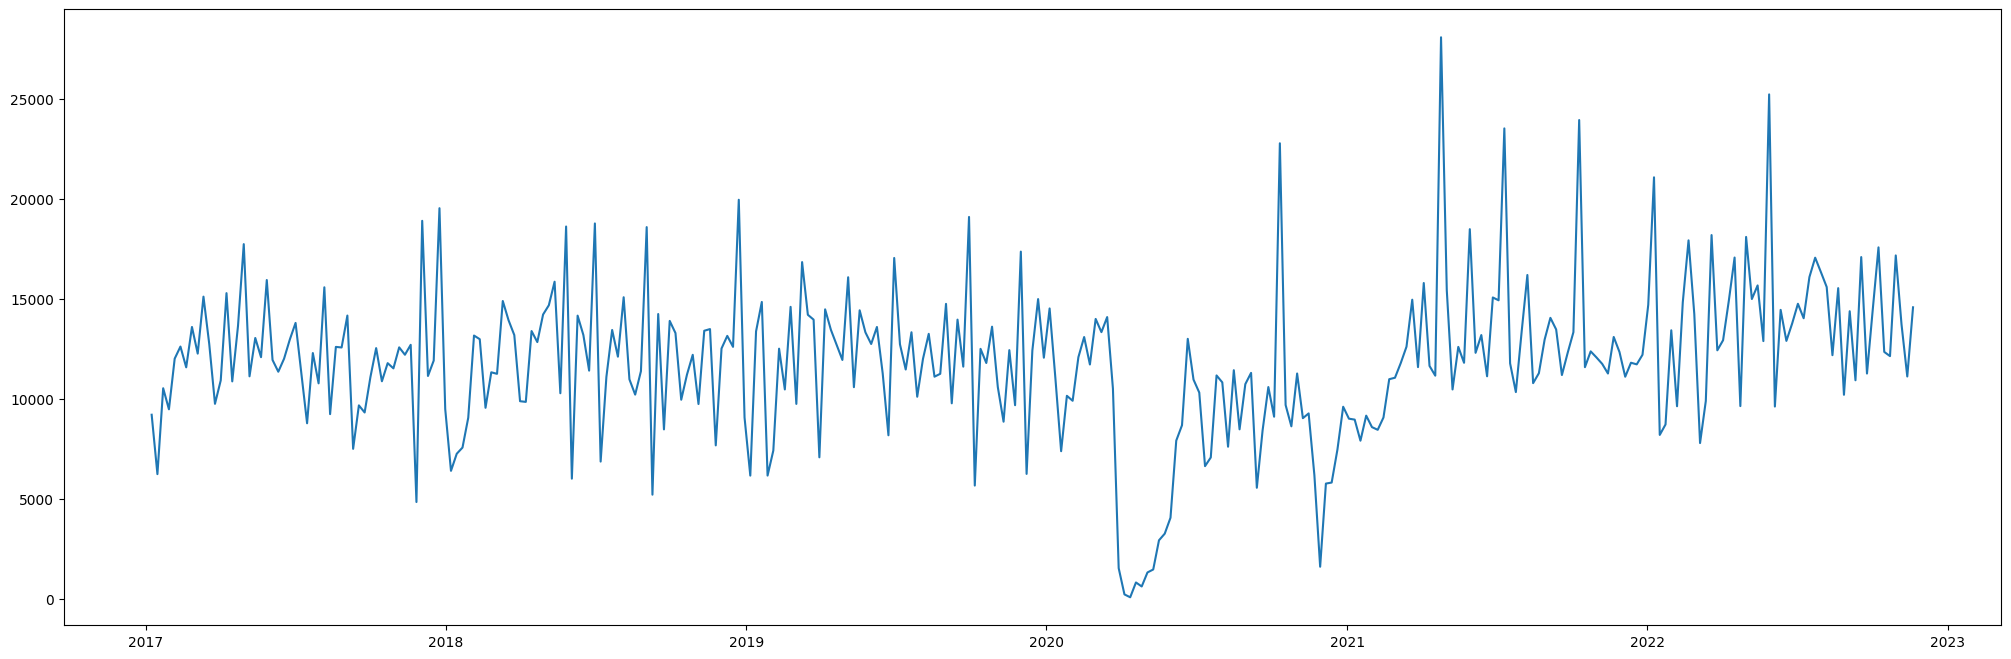

In [39]:
train_resampled_weekly = train.resample('W').sum()
fig, ax = plt.subplots(figsize=(25, 8))
ax.plot(train_resampled_weekly);

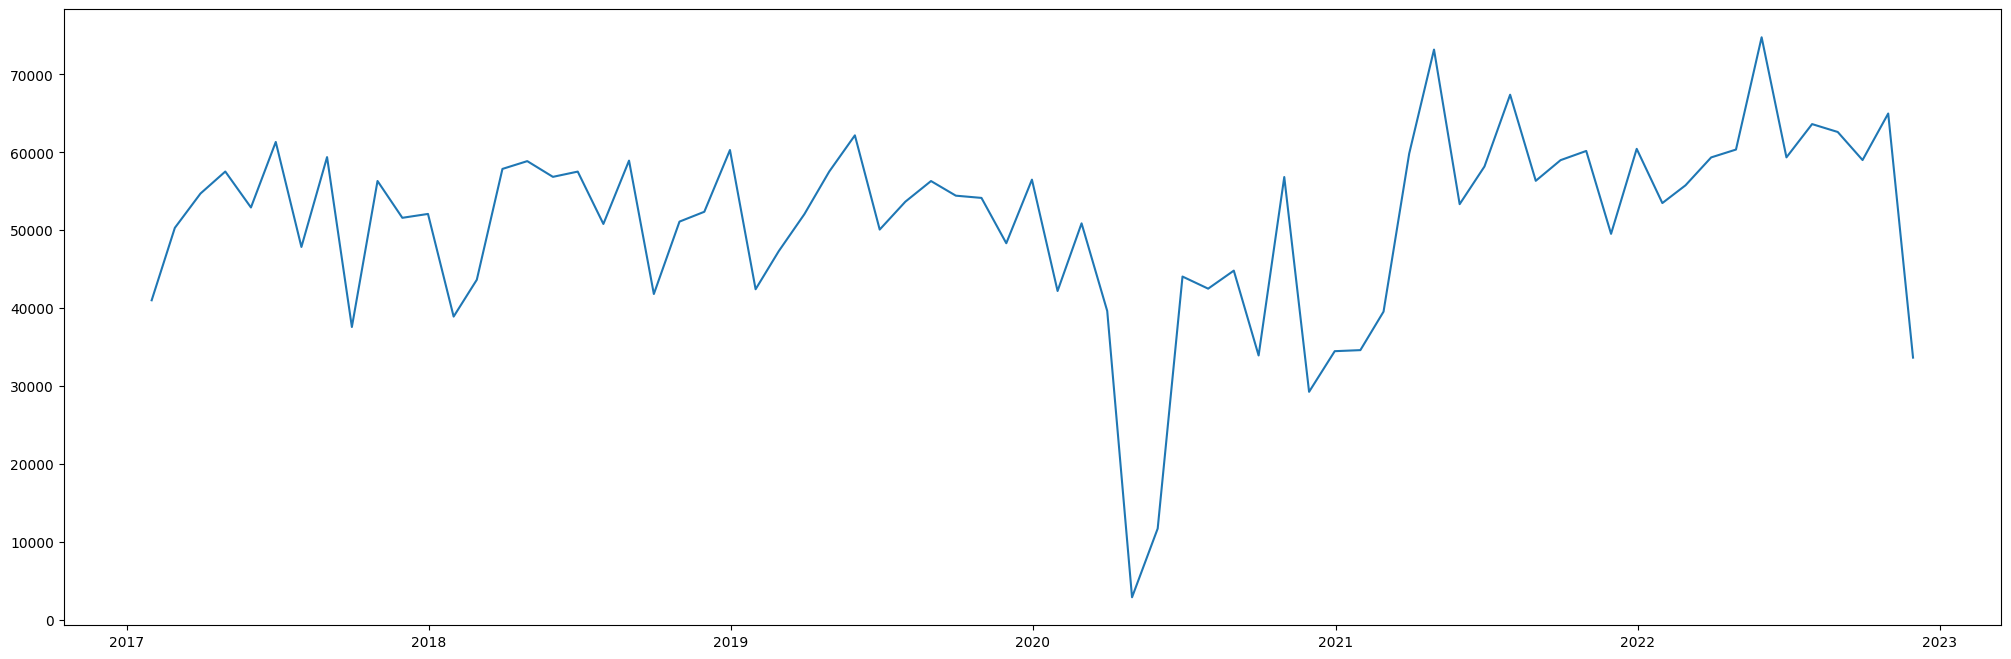

In [40]:
train_resampled_month = train.resample('M').sum()
fig, ax = plt.subplots(figsize=(25, 8))
ax.plot(train_resampled_month);

It seems like we might be looking at peaks around the 4th of July and lulls every fall, but these peaks & troughs vary.

To be sure, let's check the ACF & PACF to see if there are any lags in the data or if we can gain any insights into ARIMA hyperparameter-tuning.

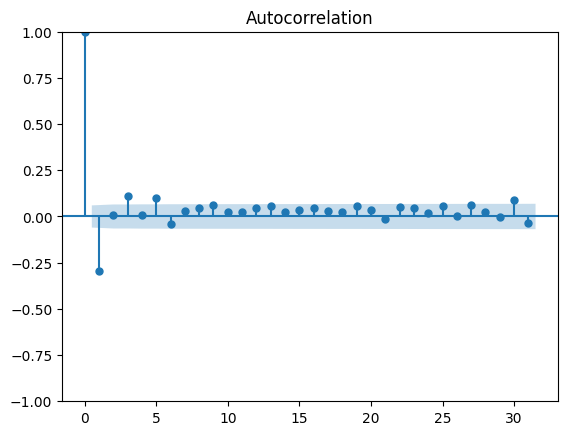

In [41]:
plot_acf(train);

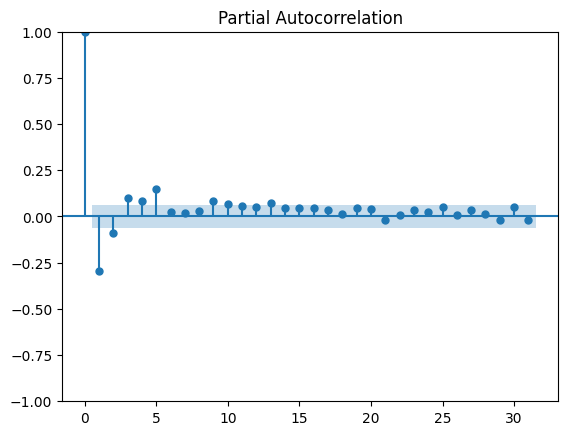

In [42]:
plot_pacf(train);

These plots aren't pointing to any obvious seasonality just yet, but it's definitely important to try different ARIMA parameters at least up to three lags to see what we'll find.

Let's just run a couple "baseline" ARIMAs (white-noise & random walk) and see how it looks.

In [43]:
#X_train_arima = X_train_encoded.drop(['Store Number', 'Vendor Name', 'Sale (Dollars)'], axis=1)
ar_white_noise_baseline = ARIMA(train, order=(0,0,0)).fit()
ar_white_noise_baseline.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           Bottles Sold   No. Observations:                 1066
Model:                          ARIMA   Log Likelihood              -13319.521
Date:                Tue, 25 Jun 2024   AIC                          26643.043
Time:                        17:40:45   BIC                          26652.986
Sample:                             0   HQIC                         26646.810
                               - 1066                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3413.3752   1.06e+05      0.032      0.974   -2.05e+05    2.12e+05
sigma2      1.133e+10   6.95e+08     16.310      0.000    9.97e+09    1.27e+10
===================================================================================
Ljung-Box (L1) (Q):                  92.78   Jarque-Bera (JB):               101.39
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.25   Skew:                             0.72
Prob(H) (two-sided):                  0.04   Kurtosis:                         3.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Even though the AIC is a metric that should be compared relative to other iterations of an ARIMA model, 26,887 seems really high. We find out later that it's due to the gaps in the time-series index when it's grouped by day.

Let's take a closer look at that index by examining the first few entries:

In [44]:
train[0:30]

Date
2017-01-03    3201
2017-01-05    6005
2017-01-09    2258
2017-01-12    3979
2017-01-16    5287
2017-01-17     241
2017-01-19    5001
2017-01-23    3828
2017-01-26    5649
2017-01-30    5470
2017-01-31      96
2017-02-02    6444
2017-02-06    3723
2017-02-09    8879
2017-02-10      12
2017-02-13    4008
2017-02-16    7555
2017-02-17      12
2017-02-20    4702
2017-02-23    8892
2017-02-27    6081
2017-03-02    6169
2017-03-03      12
2017-03-06    5428
2017-03-09    9681
2017-03-13    6512
2017-03-14     458
2017-03-15     730
2017-03-16    5049
2017-03-20    3476
Name: Bottles Sold, dtype: int64

Irregularities in the dates means the *frequency* of days isn't consistent, so it won't be able to forecast consistently.

This is a little annoying because I wanted to keep the time-series data on a daily scale since major grocers restock daily, but it looks like we'll have to resample to at least the weekly basis in order for ARIMA to be able to forecast.

In [45]:
#replace 'train' with the preexisting weekly version we made above
train = train_resampled_weekly
#retry ARIMA
ar_white_noise_baseline = ARIMA(train, order=(0,0,0)).fit()
ar_white_noise_baseline.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           Bottles Sold   No. Observations:                  307
Model:                          ARIMA   Log Likelihood               -2970.820
Date:                Tue, 25 Jun 2024   AIC                           5945.639
Time:                        17:40:45   BIC                           5953.093
Sample:                    01-08-2017   HQIC                          5948.620
                         - 11-20-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.185e+04    224.292     52.843      0.000    1.14e+04    1.23e+04
sigma2      1.515e+07   8.54e+05     17.738      0.000    1.35e+07    1.68e+07
===================================================================================
Ljung-Box (L1) (Q):                  24.59   Jarque-Bera (JB):                65.30
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.88   Skew:                             0.08
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

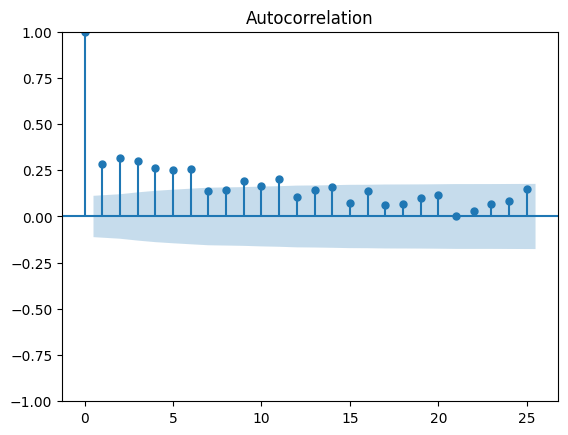

In [46]:
plot_acf(train);

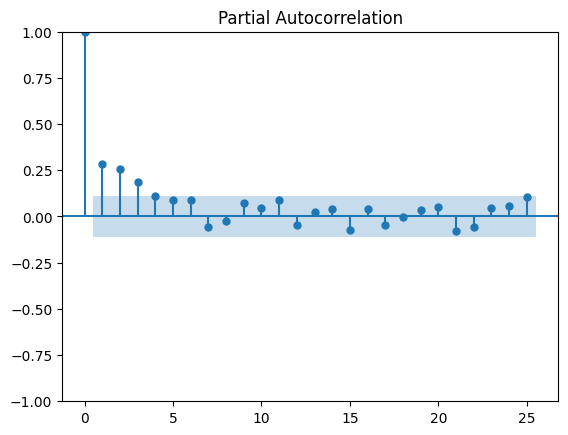

In [47]:
plot_pacf(train);

Looks like that solved the index problem; the ACF/PACF plots look more like what we'd expect, and we'll be able to forecast once we're finished optimizing the model. **Normally, this is where we'd decide to simply skip ARIMA and move straight to a SARIMA model to account for some seasonality.** However, running that many hyperparameter settings via a parameter grid seems to be a little much on Google Colab - it takes too long and eats up a lot of RAM.

In this instance, **a workaround involves first running a baseline and then a parameter grid via ARIMA, then co-opting those params for SARIMA's p/d/q *and* P/D/Q seasonal settings.**

Looking ahead, we have an AIC score of 6,051 with this white noise baseline model. Let's also see how it looks with a random walk baseline:

In [48]:
ar_random_walk_baseline = ARIMA(train, order=(0,1,0)).fit()
ar_random_walk_baseline.aic

6035.461022932946

Things are improving, but we'll probably see substantially better results once we swtich over to SARIMA. Before we do soe, let's also run a **cross-validated RMSE** to evaluate these different ARIMA settings.

In [49]:
def cv_ts_rmse(model, train_data=train):
  #resetting the index for easier splitting for the RMSE
  train_with_ind = train_data.reset_index()
  #empty list to hold each fold's RMSE
  RMSEs = []
  #iterate through folds and append RMSE
  for train_ind, val_ind in split.split(train_with_ind):
    ar = ARIMA(endog=train_with_ind.iloc[train_ind, -1], order=(0, 0, 0)).fit()
    preds = ar.predict(start=val_ind[0], end=val_ind[-1])
    true = train_with_ind.iloc[val_ind, -1]
    RMSEs.append(np.sqrt(mean_squared_error(true, preds)))
  #return the mean of all RMSEs
  RMSE_mean = np.mean(RMSEs)
  return RMSE_mean

In [50]:
#testing it out on our lowest-AIC model so far
cv_ts_rmse(ar_white_noise_baseline)

4046.7721600349178

Now let's see whether we can improve on this 6,051 AIC and 4,237 RMSE with a parameter grid. Due to RAM and runtime limits, let's just go up to 3 lags/differences/moving-averages. We'll put this into a function we can use for the remainder of this project:

In [82]:
def optimize_ARIMA(train_data=train):

  #define ARIMA order params:
  param_grid = {'p': [1,2,3],
                'd': [1,2,3],
                'q': [1,2,3]}
  #turn them into a ParameterGrid
  grid = ParameterGrid(param_grid)
  #empty dictionary for holding AIC scores:
  AICs = {}
  #empty dictionary for holding RMSE scores:
  RMSEs = {}
  #iterate through params and append the AICs scores
  for params in grid:
    #this block will get the AIC score and the respective model order params
    # and won't run models whose params aren't invertible
    try:
      model = ARIMA(train_data,
                  order = (params['p'],
                           params['d'],
                           params['q'])).fit(method_kwargs={'maxiter':300})
      new_key = model.aic
      new_value = params
      AICs[new_key] = new_value
    except:
      continue

    #this block runs a cross-validated RMSE function on that same model
    #resetting the index for easier splitting for the RMSE
    train_with_ind = train_data.reset_index()
    #empty dictionary to hold each model's mean RMSE
    mean_RMSEs = {}
    #iterate through folds and append RMSE
    #empty list to hold each fold's RMSE
    for train_ind, val_ind in split.split(train_with_ind):
      fold_RMSEs = []
      preds = model.predict(start=val_ind[0], end=val_ind[-1])
      true = train_with_ind.iloc[val_ind, -1]
      fold_RMSEs.append(np.sqrt(mean_squared_error(true, preds)))
    #return the mean of all RMSEs
    RMSE_mean = np.mean(fold_RMSEs)
    new_RMSE_key = RMSE_mean
    RMSEs[new_RMSE_key] = params

  #return lowest AIC & RMSE
  lowest_AIC = min(AICs.items(), key=lambda x: x[0])
  lowest_RMSE = min(RMSEs.items(), key=lambda x: x[0])
  print("model with the lowest AIC score (score, then params):", lowest_AIC)
  print("model with the lowest RMSE score (score, then params):", lowest_RMSE)

In [83]:
optimize_ARIMA(train)

model with the lowest AIC score (score, then params_): (4464.917013634473, {'d': 2, 'p': 1, 'q': 2})
model with the lowest RMSE score (score, then params_): (444.544027943803, {'d': 1, 'p': 2, 'q': 3})


I wanted to use two metrics to see whether they would agree on the optimal model, but they don't. [AIC penalizes models as they grow more complex while RMSE doesn't](https://stats.stackexchange.com/a/339971/378499). In other words, AIC may make for a simpler interpretation while RMSE priveledges accuracy.

Let's see how these two models compare when run against the larger test data.

In [53]:
arima_233 = ARIMA(train, order = (2,3,3)).fit(method_kwargs={'maxiter':300})
arima_113 = ARIMA(train, order = (1,1,3)).fit(method_kwargs={'maxiter':300})

In [54]:
#first we'll need to resample the test set on a weekly basis
test = test.resample('W').sum()
#define the RMSE function
def find_rmse_test(model, test_data=test):
    y_hat = model.predict(start=test_data.index[0], end=test_data.index[-1])
    return np.sqrt(mean_squared_error(test_data, y_hat))
#running the function
print('ARIMA model order (2,3,3) RMSE:', find_rmse_test(arima_233))
print('ARIMA model order (1,1,3) RMSE:', find_rmse_test(arima_113))

ARIMA model order (2,3,3) RMSE: 4181.325171232999
ARIMA model order (1,1,3) RMSE: 4431.506332407843


When it comes to the test data, the model with the lowest AIC (arima_233) performed a bit better, but the RMSE on the test set (5,010) was worse than the training set (4,122). Something's definitely off (spoiler alert: it's the seasonality); let's visualize these predictions on the test data:

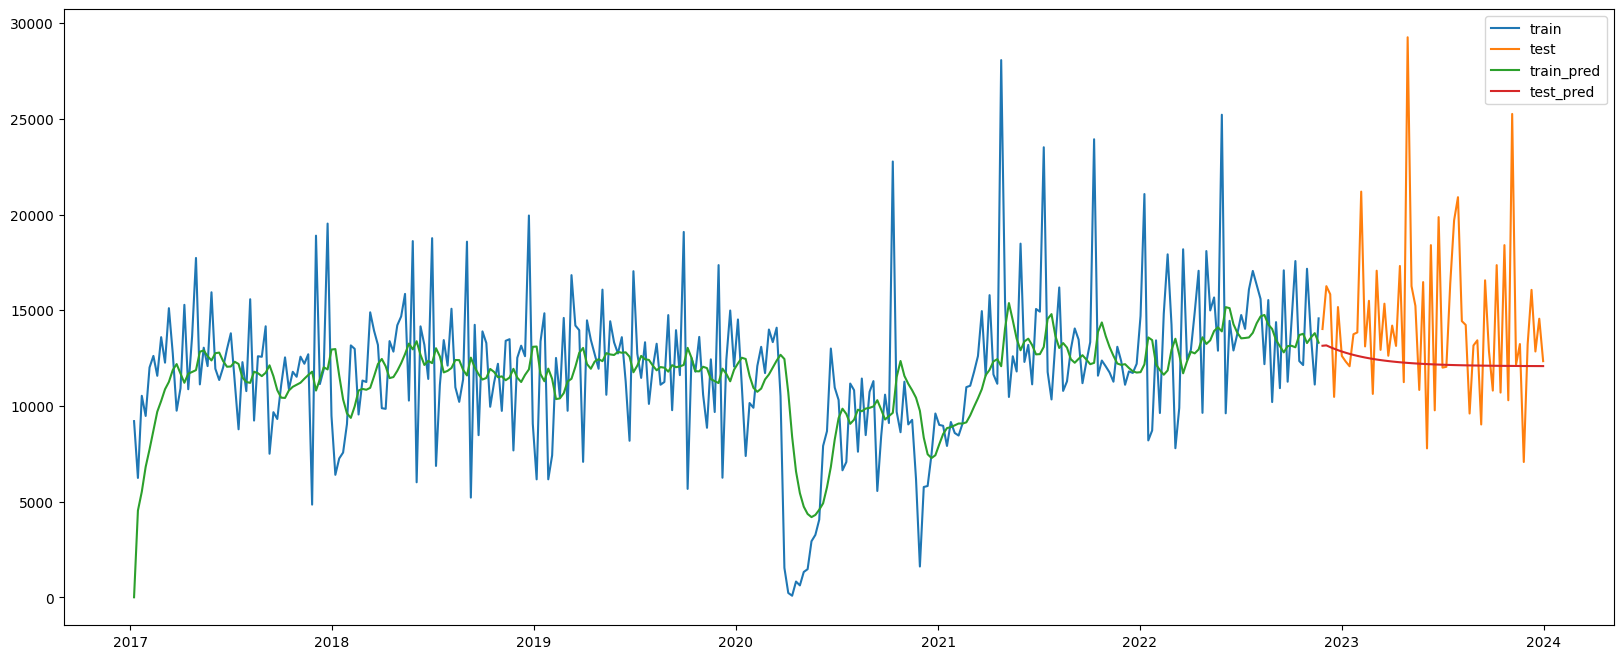

In [55]:
y_hat_train = arima_113.predict()
y_hat_test = arima_113.predict(start=test.index[0], end=test.index[-1])

fig, ax = plt.subplots(figsize=(20,8))
ax.plot(train, label='train')
ax.plot(test, label='test')
ax.plot(y_hat_train, label='train_pred')
ax.plot(y_hat_test, label='test_pred')

plt.legend();

We can confirm that these predictions are failing to account for seasonality. Let's recheck the ACF plot with more lags in the picture.

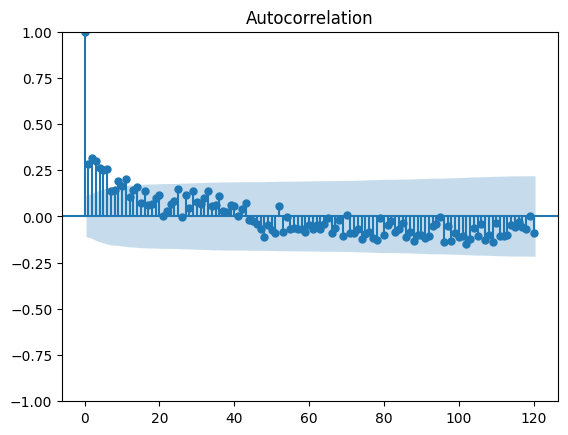

In [56]:
plot_acf(train, lags=120);

Ah, it's not overt, but there's *some* seasonality going on and some definite autocorrelation, meaning this data isn't stationary even if it did pass the trend test with the augmented Dickey-Fuller metric. Subsequently, we'll need to refine our model from ARIMA to SARIMA to take these seasonal effects into account.

In [57]:
sar_113 = SARIMAX(train,
                  order = (1,1,3),
                  seasonal_order = (1,1,3,52)).fit()
sar_113.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                       Bottles Sold   No. Observations:                  307
Model:             SARIMAX(1, 1, 3)x(1, 1, 3, 52)   Log Likelihood               -2471.614
Date:                            Tue, 25 Jun 2024   AIC                           4961.229
Time:                                    17:45:59   BIC                           4993.065
Sample:                                01-08-2017   HQIC                          4974.036
                                     - 11-20-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8850      0.198      4.463      0.000       0.496       1.274
ma.L1         -1.6742      0.211     -7.923      0.000      -2.088      -1.260
ma.L2          0.7742      0.207      3.737      0.000       0.368       1.180
ma.L3         -0.0834      0.096     -0.869      0.385      -0.271       0.105
ar.S.L52      -0.9882      1.125     -0.878      0.380      -3.194       1.217
ma.S.L52       0.3168      1.277      0.248      0.804      -2.186       2.819
ma.S.L104     -0.6316      0.783     -0.807      0.420      -2.166       0.903
ma.S.L156      0.0195      0.200      0.097      0.922      -0.373       0.412
sigma2      2.231e+07   1.25e-06   1.78e+13      0.000    2.23e+07    2.23e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):                44.71
Prob(Q):                              0.72   Prob(JB):                         0.00
Heteroskedasticity (H):               2.11   Skew:                             0.36
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.47e+28. Standard errors may be unstable.
"""

Okay, we see a better AIC score, what about the RMSE. Let's compare the test-set RMSE fromt he ARIMA model against SARIMA:

Okay, I guess I'm missing something here.

In [58]:
find_rmse_test(arima_113)

4431.506332407843

In [59]:
find_rmse_test(sar_113)

4079.7863455019183

The SARIMA model is performing better than the ARIMA on the test set, which is is great. Let's visualize these results:

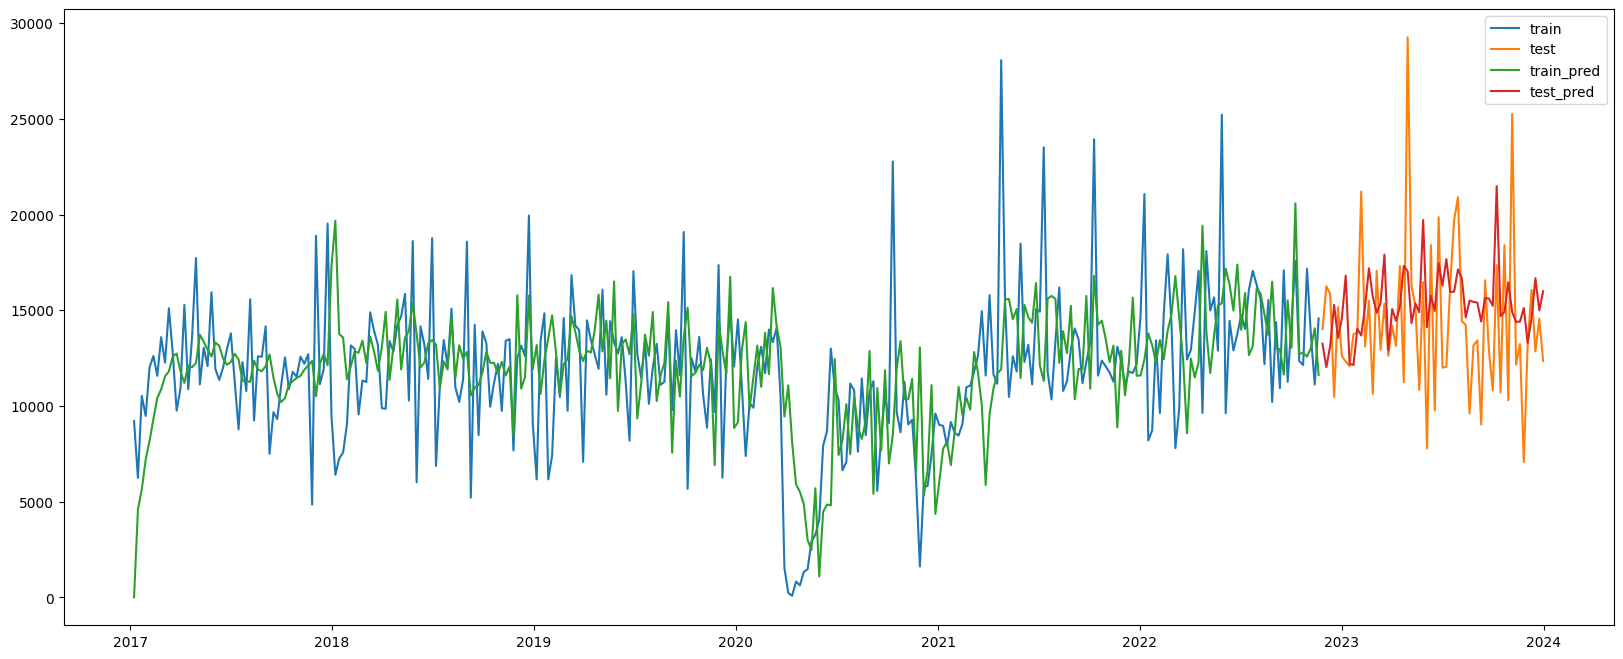

In [60]:
y_hat_train = sar_113.predict()
y_hat_test = sar_113.predict(start=test.index[0], end=test.index[-1])

fig, ax = plt.subplots(figsize=(20,8))
ax.plot(train, label='train')
ax.plot(test, label='test')
ax.plot(y_hat_train, label='train_pred')
ax.plot(y_hat_test, label='test_pred')

plt.legend();

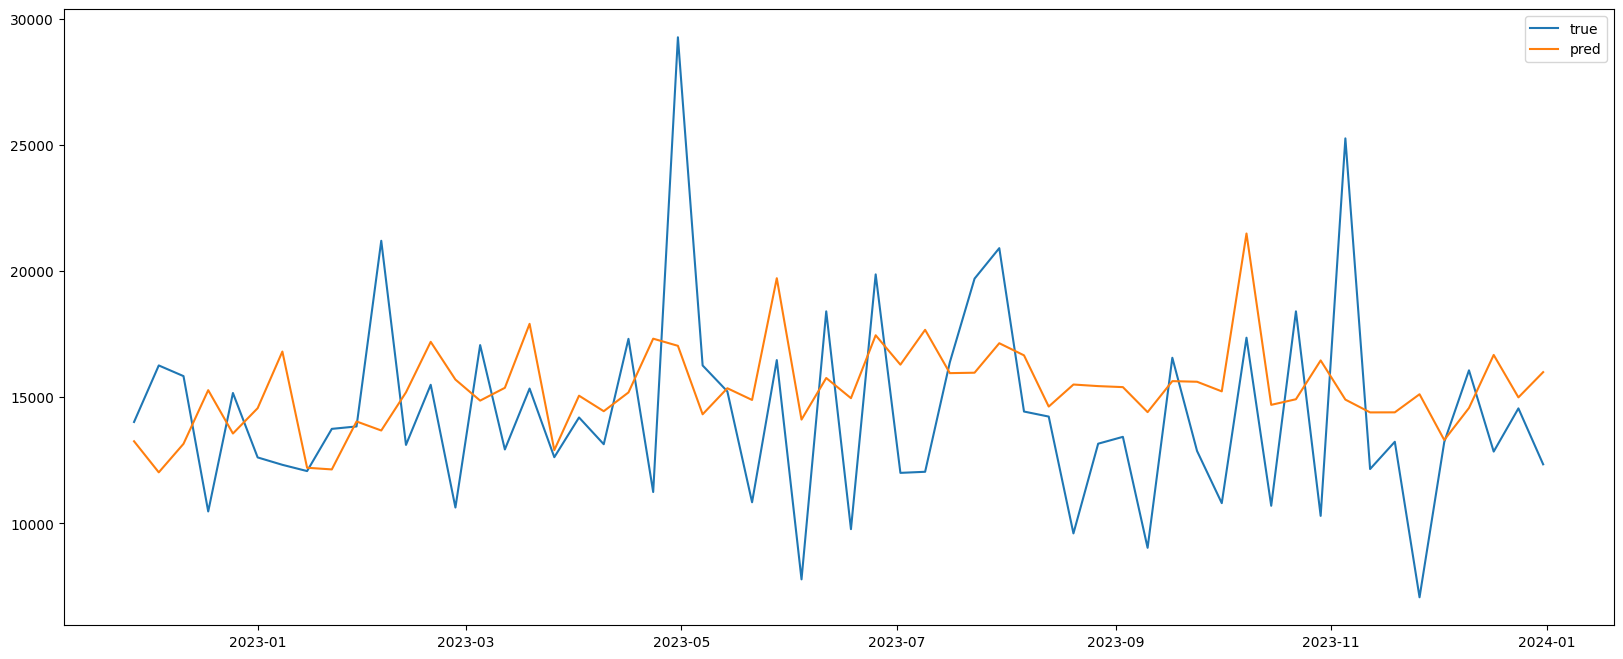

In [61]:
# Let's zoom in on test
fig, ax = plt.subplots(figsize=(20,8))

ax.plot(test, label='true')
ax.plot(y_hat_test, label='pred')

plt.legend();

Not great, but not bad. Let's finally forecast with all this data from the Hy-Vee in Des Moines.

In [62]:
hvdm_weekly = hvdm.resample('W').sum()
sar_hvdm = SARIMAX(hvdm_weekly,
                   order=(1, 1, 3),
                   seasonal_order=(1, 1, 3, 52)).fit()

In [63]:
sar_hvdm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                       Bottles Sold   No. Observations:                  365
Model:             SARIMAX(1, 1, 3)x(1, 1, 3, 52)   Log Likelihood               -3040.203
Date:                            Tue, 25 Jun 2024   AIC                           6098.405
Time:                                    17:50:50   BIC                           6132.092
Sample:                                01-08-2017   HQIC                          6111.869
                                     - 12-31-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1989      1.199     -0.166      0.868      -2.549       2.151
ma.L1         -0.6224      1.192     -0.522      0.602      -2.960       1.715
ma.L2         -0.0551      0.971     -0.057      0.955      -1.959       1.848
ma.L3         -0.0684      0.104     -0.658      0.511      -0.272       0.135
ar.S.L52      -0.9428    108.085     -0.009      0.993    -212.785     210.900
ma.S.L52       0.2613    108.058      0.002      0.998    -211.528     212.051
ma.S.L104     -0.6618     73.654     -0.009      0.993    -145.021     143.698
ma.S.L156     -0.0173      2.149     -0.008      0.994      -4.228       4.194
sigma2      2.264e+07      0.004   5.58e+09      0.000    2.26e+07    2.26e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):                57.64
Prob(Q):                              0.71   Prob(JB):                         0.00
Heteroskedasticity (H):               1.89   Skew:                             0.48
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.25e+26. Standard errors may be unstable.
"""

In [64]:
forecast = sar_hvdm.forecast(steps=52)

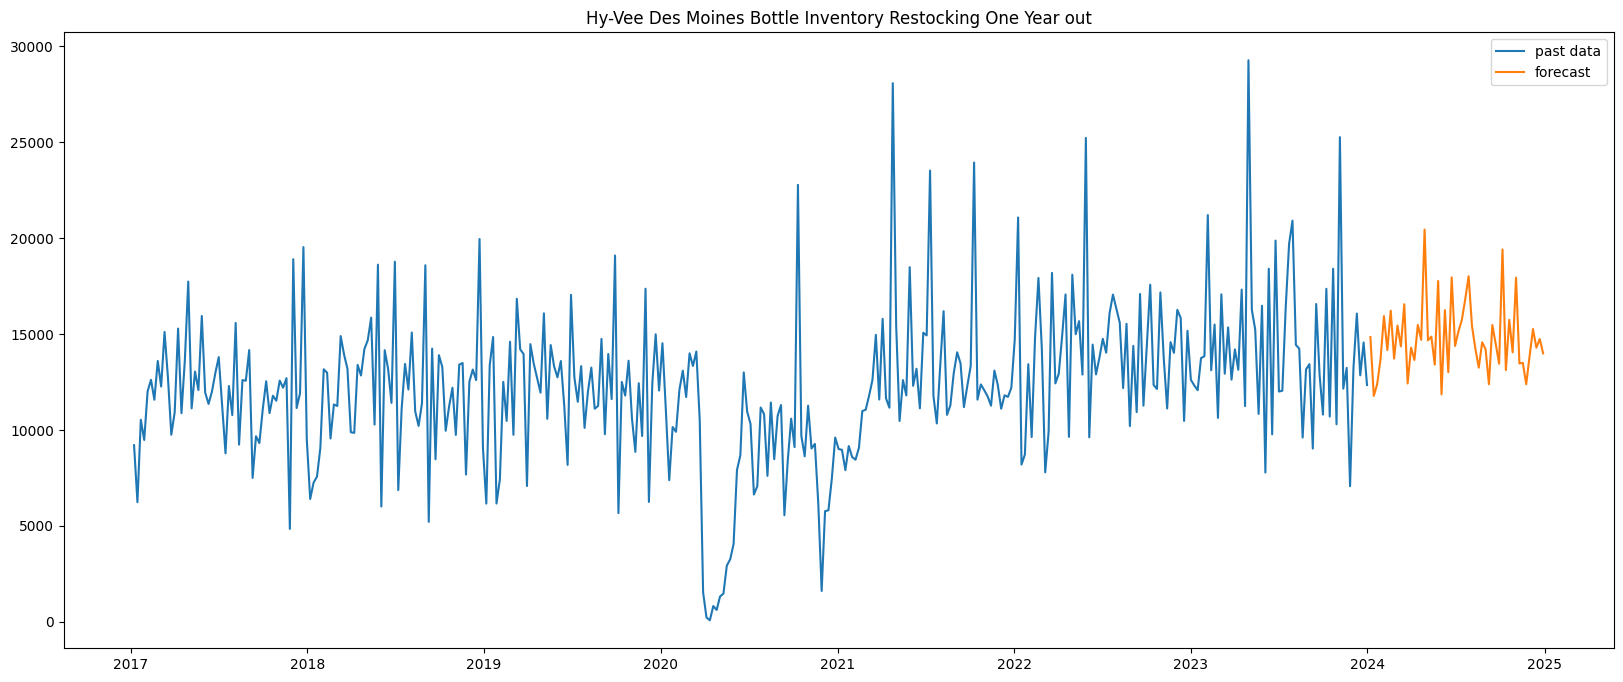

In [65]:
fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(hvdm_weekly, label='past data')
ax.plot(forecast, label='forecast')
ax.set_title('Hy-Vee Des Moines Bottle Inventory Restocking One Year out')

plt.legend();

Can I run SARIMA on categories?

In [66]:
hy_vee_des_moines

,Date,Store Number,Store Name,City,Category Name,Vendor Number,Vendor Name,Bottles Sold
140,2017-01-03,2633,HY-VEE #3 / BDI / DES MOINES,DES MOINES,VODKA FLAVORED,259.0,HEAVEN HILL BRANDS,12
153,2017-01-03,2633,HY-VEE #3 / BDI / DES MOINES,DES MOINES,SCOTCH WHISKIES,35.0,BACARDI USA INC,12
4944,2017-01-03,2633,HY-VEE #3 / BDI / DES MOINES,DES MOINES,TEQUILA,434.0,LUXCO INC,1
4979,2017-01-03,2633,HY-VEE #3 / BDI / DES MOINES,DES MOINES,GIN,35.0,BACARDI USA INC,24
4992,2017-01-03,2633,HY-VEE #3 / BDI / DES MOINES,DES MOINES,LIQUEUR,978.0,W J DEUTSCH & SONS LTD,4
...,...,...,...,...,...,...,...,...
17458053,2023-12-29,2633,HY-VEE #3 / BDI / DES MOINES,DES MOINES,TEQUILA,35.0,BACARDI USA INC,348
17458277,2023-12-29,2633,HY-VEE #3 / BDI / DES MOINES,DES MOINES,VODKA FLAVORED,260.0,DIAGEO AMERICAS,12
17458382,2023-12-29,2633,HY-VEE #3 / BDI / DES MOINES,DES MOINES,GIN,654.0,REVELTON DISTILLING COMPANY,180
17458400,2023-12-29,2633,HY-VEE #3 / BDI / DES MOINES,DES MOINES,VODKA FLAVORED,260.0,DIAGEO AMERICAS,12


In [67]:
hy_vee_des_moines = trimmed_df[trimmed_df['Store Number'] == 2633]
hvdm_rum = hy_vee_des_moines[hy_vee_des_moines['Category Name'] == 'RUM']
hvdm_rum = hvdm_rum.groupby('Date').sum()['Bottles Sold']
hvdm_rum = hvdm_rum.resample('W').sum()
hvdm_rum

Date
2017-01-08     733
2017-01-15    1192
2017-01-22    1306
2017-01-29    1479
2017-02-05    1469
              ... 
2023-12-03     774
2023-12-10    2010
2023-12-17    1158
2023-12-24    1506
2023-12-31    1362
Freq: W-SUN, Name: Bottles Sold, Length: 365, dtype: int64

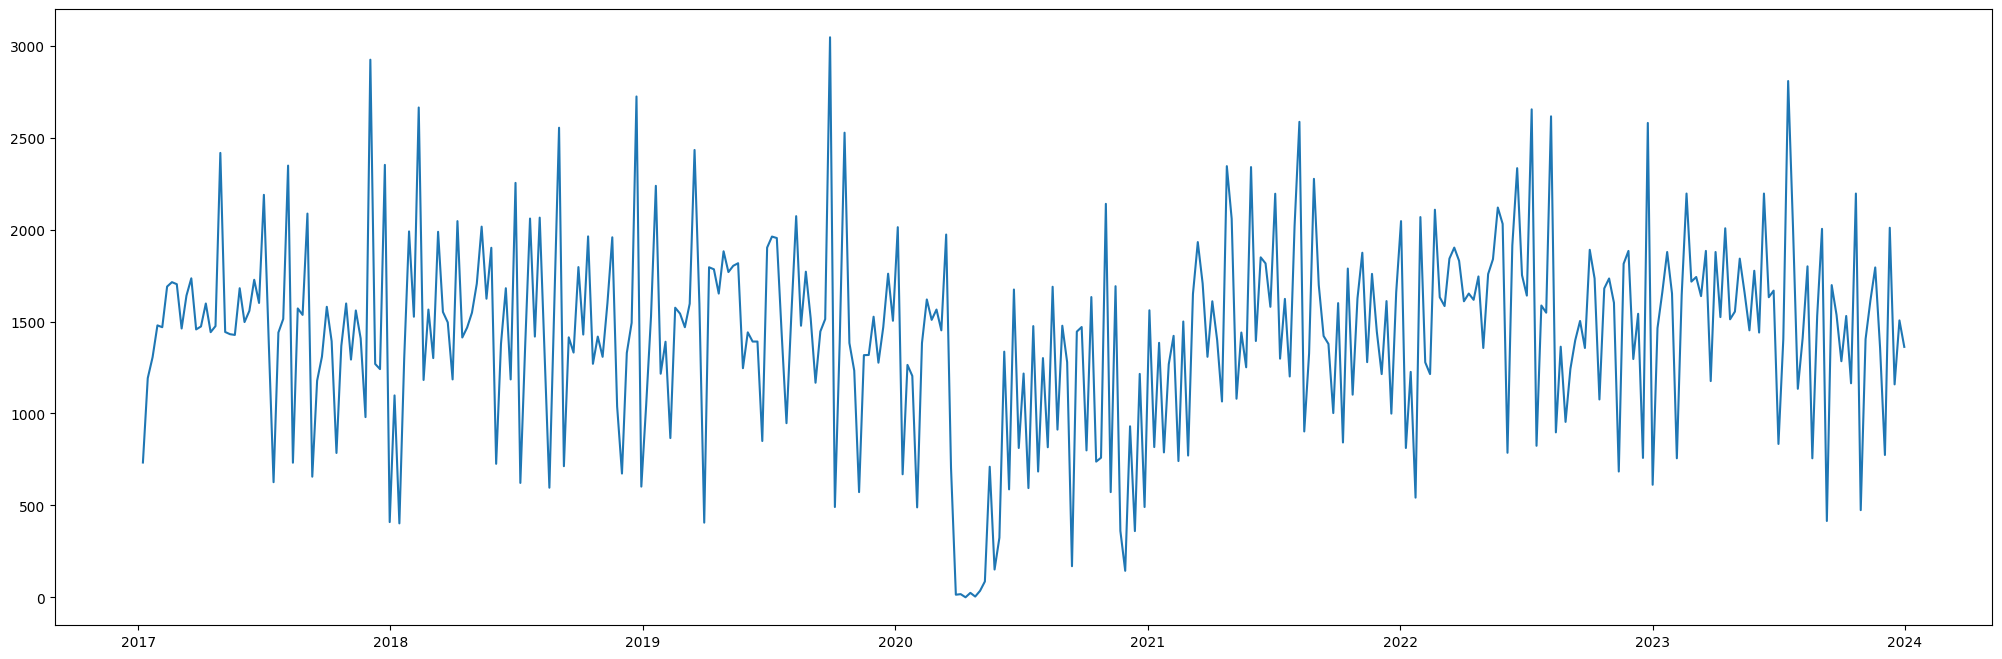

In [81]:
fig, ax = plt.subplots(figsize=(25, 8))
ax.plot(hvdm_rum);

In [84]:
cutoff = round(hvdm_rum.shape[0]*0.8)
# Define train and test sets according to the index found above
train = hvdm_rum[:cutoff]
test = hvdm_rum[cutoff:]
# TimeSeriesSplit
split = TimeSeriesSplit()

for train_ind, val_ind in split.split(train):
    print(f'Train index: {train_ind}')
    print(f'Test  index: {val_ind}')

Train index: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51]
Test  index: [52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75
 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99]
Train index: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]
Test  index: [100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117
 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135
 136 137 138 139 140 141 142 143 144 145 146 147]
Train index: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30 

In [85]:
adfuller(train)

(-3.9854409886124307,
 0.0014886948085426805,
 4,
 287,
 {'1%': -3.453342167806272,
  '5%': -2.871663828287282,
  '10%': -2.572164381381345},
 4226.935912235356)

In [86]:
optimize_ARIMA(train)

model with the lowest AIC score (score, then params_): (4464.917013634473, {'d': 2, 'p': 1, 'q': 2})
model with the lowest RMSE score (score, then params_): (444.544027943803, {'d': 1, 'p': 2, 'q': 3})


In [87]:
#I found linear algebra errors were thrown with the lower RMSE model, so let's try the
# one with the lowest AIC this time:
#sarima_rum_213 = SARIMAX(train,
#                         order = (2,1,3),
#                         seasonal_order = (2,1,3,52)).fit()
#sarima_rum_213.summary()
sarima_rum_122 = SARIMAX(train,
                         order = (1,2,2),
                         seasonal_order = (1,2,2,52)).fit()
sarima_rum_122.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                       Bottles Sold   No. Observations:                  292
Model:             SARIMAX(1, 2, 2)x(1, 2, 2, 52)   Log Likelihood               -1511.450
Date:                            Tue, 25 Jun 2024   AIC                           3036.900
Time:                                    18:35:46   BIC                           3059.481
Sample:                                01-08-2017   HQIC                          3046.051
                                     - 08-07-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0894      0.104     -0.856      0.392      -0.294       0.115
ma.L1         -1.8063      5.080     -0.356      0.722     -11.764       8.151
ma.L2          0.8063      4.096      0.197      0.844      -7.222       8.834
ar.S.L52      -0.0214      0.456     -0.047      0.963      -0.915       0.872
ma.S.L52      -1.6429      4.715     -0.348      0.728     -10.885       7.599
ma.S.L104      0.7014      2.738      0.256      0.798      -4.666       6.069
sigma2      3.643e+05   2.28e-05    1.6e+10      0.000    3.64e+05    3.64e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 0.40
Prob(Q):                              0.87   Prob(JB):                         0.82
Heteroskedasticity (H):               1.17   Skew:                             0.04
Prob(H) (two-sided):                  0.53   Kurtosis:                         2.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.4e+27. Standard errors may be unstable.
"""

In [109]:
y_hat_train = sarima_rum_122.predict()
y_hat_test = sarima_rum_122.predict(start=test.index[0], end=test.index[-1])

print('sarima_rum_122 train RMSE:', np.sqrt(mean_squared_error(train, y_hat_train)))
print('sarima_rum_122 test RMSE:', np.sqrt(mean_squared_error(test, y_hat_test)))

sarima_rum_122 train RMSE: 877.0258556984162
sarima_rum_122 test RMSE: 1031.727857788516


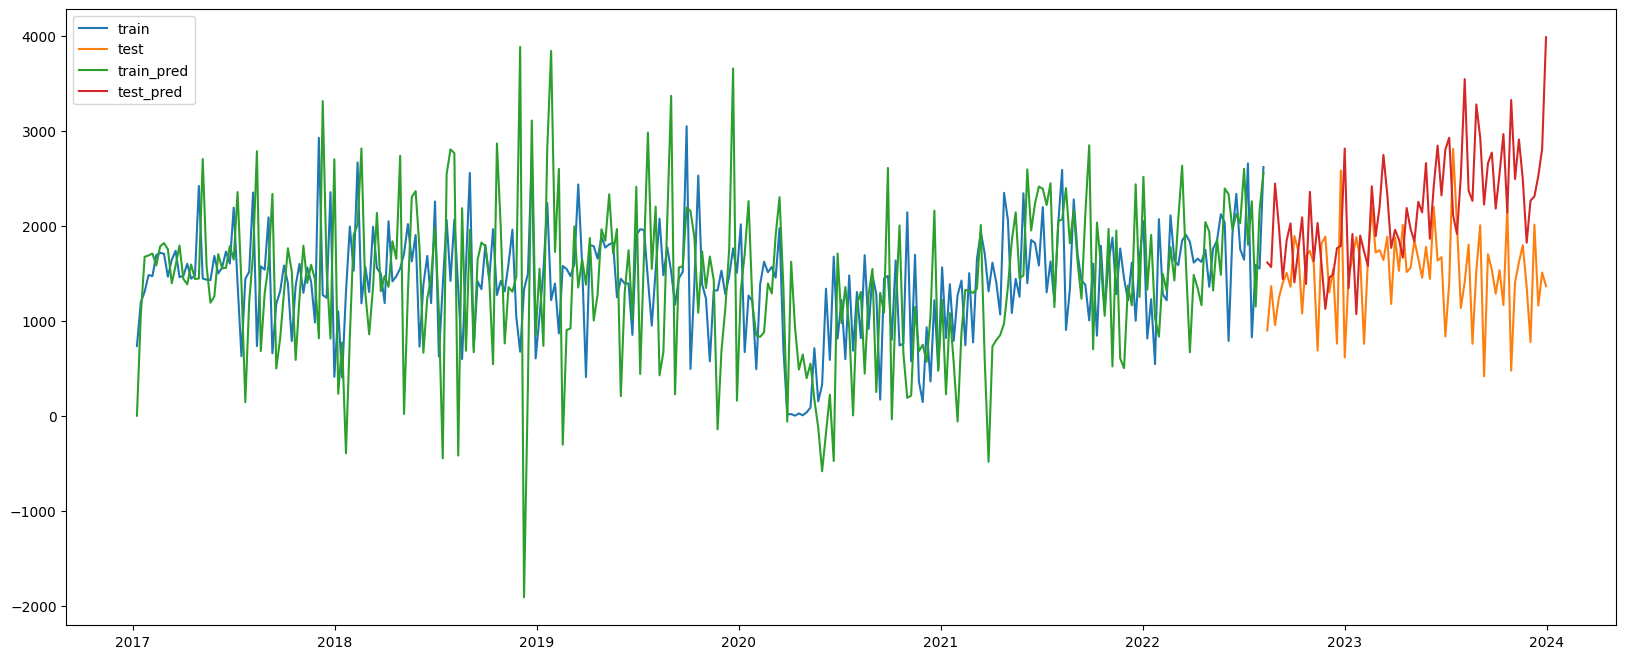

In [90]:
fig, ax = plt.subplots(figsize=(20,8))
ax.plot(train, label='train')
ax.plot(test, label='test')
ax.plot(y_hat_train, label='train_pred')
ax.plot(y_hat_test, label='test_pred')

plt.legend();

In [91]:
sar_hvdm_rum = SARIMAX(hvdm_rum,
                       order=(1, 2, 2),
                       seasonal_order=(1, 2, 2, 52)).fit()

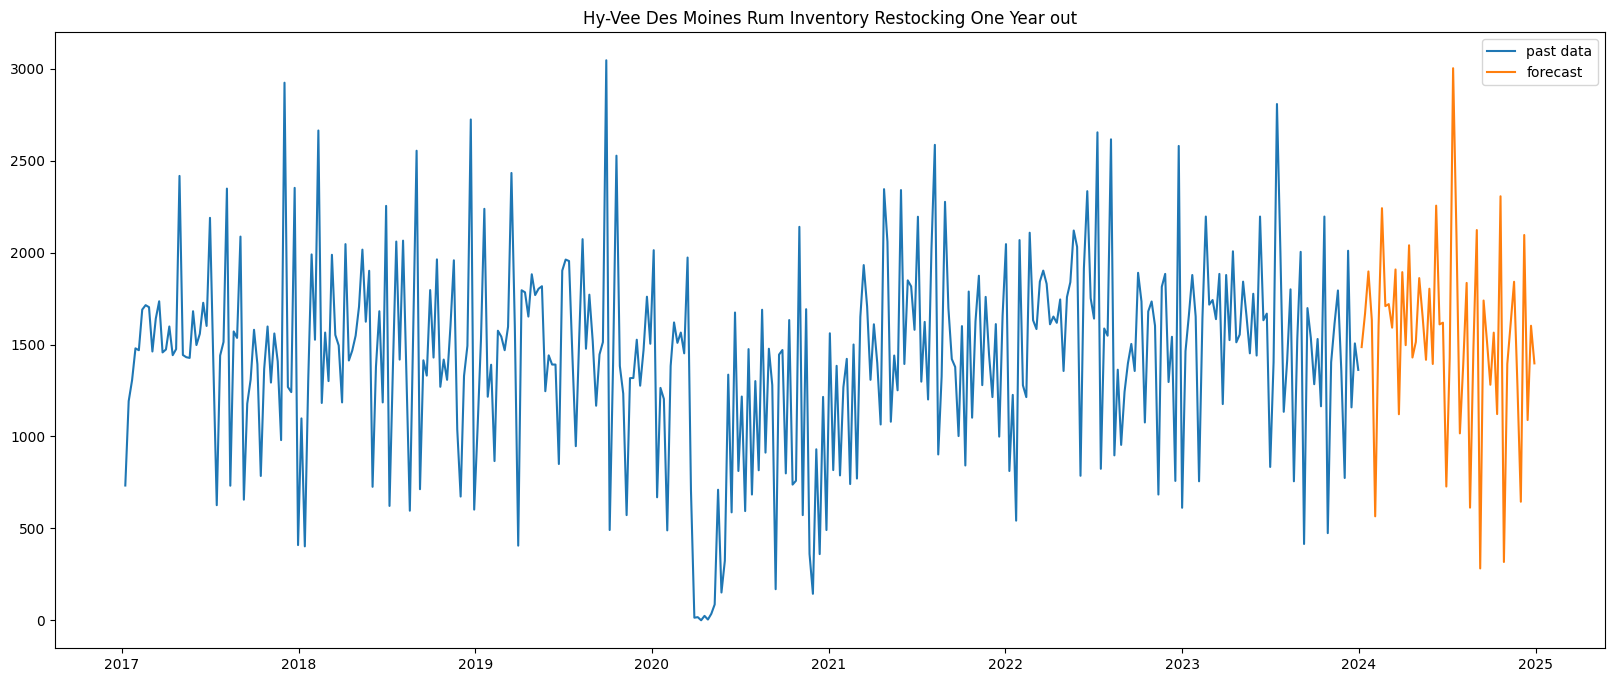

In [94]:
fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(hvdm_rum, label='past data')
ax.plot(forecast, label='forecast')
ax.set_title('Hy-Vee Des Moines Rum Inventory Restocking One Year out')

plt.legend();

## streamlining this modeling process for liqour categories

We did a lot in order to finally reach the forecasting stage above. It involved a time-series split, resampling on a weekly basis, testing for trends, optimizing ARIMA parameters, discovering the data had seasonality even though I thought it didn't, recalibrating the test for SARIMA, and writing a few functions along the way.

Part of what took a while was getting to know this data on a smaller, store-specific scale. If we want to take this process and run it on a number of other stores in Iowa, we'd need to streamline this process by eliminating some of the EDA-like steps we took along the way above. We'd also want to automate a few steps like the weekly resampling and time-series-split via a Pipeline.

The original goal of this project was to write a function that takes in an individual store's data from our earlier 'trimmed_df' and not only preprocesses the data, but optimizes a SARIMA model on it, evaluates the predictions on the train & test sets, then forecasts for the next year. However, this process proved to be too computationally expensive and would run too long and/or crash the Google Colab notebook runtime session. What's more is it seems like completely automating a (S)ARIMA modeling process is problematic; evaluating the data for trends, stationality, and determining whether AIC or RMSE work as a better metric in the optimization process are proving to be processes best done on a case-by-case basis.

Subsequently, the function below will limit streamlining to the preprocessing & valuation steps as well as beginning the optimization process (via the preestablished optimize_ARIMA function), but will leave the fitting of the *SARIMA* model to the user. From there, we can also fit the evaluation on the test set (including the visualizing) along with the forecasting to a second function.

We've already done a lot of the work that goes into this process; this is more of a matter of combining everything into two functions.

In [117]:
#the input is a liquor category from the Hy-Vee Des Moines dataset as a string

def HVDM_preprocess_and_optimize_ARIMA(liquor_category):

  #PREPROCESSING

  #getting the relevant category from
  category = hy_vee_des_moines[hy_vee_des_moines['Category Name'] == liquor_category]
  # turn data into a series and resample on a weekly basis
  category = category.groupby('Date').sum()['Bottles Sold']
  category = category.resample('W').sum()

  #EVALUATION

  # find the index which allows us to split off 20% of the data
  cutoff = round(category.shape[0]*0.8)
  # Define train and test sets according to the index found above
  train = category[:cutoff]
  test = category[cutoff:]

  #MODELING via a more lightweight ARIMA process
  optimize_ARIMA(train)

In [118]:
#testing it out with the previously used rum subset
#hvdm_rum = hy_vee_des_moines[hy_vee_des_moines['Category Name'] == 'RUM']
HVDM_preprocess_and_optimize_ARIMA('RUM')

model with the lowest AIC score (score, then params_): (4464.917013634473, {'d': 2, 'p': 1, 'q': 2})
model with the lowest RMSE score (score, then params_): (444.544027943803, {'d': 1, 'p': 2, 'q': 3})


So far, so good - we get the same results that we got earlier. At this point, we'd need to have the flexibility to run either the model with the lowest AIC or the lowest RMSE. This is due to what we've found before: sometimes the lowest RMSE model works the best, sometimes it results in a "LU decomposition error".

Subsequently, we'll try and streamline the SARIMA fitting as much as possible, where all that's needed for input is the same liquor category data as before along with the params from one of the models (specifically, three integers with commas between them):

In [167]:
def SARIMA_fit_and_forecast(same_liquor_category,p,d,q):

  #(RE)PREPROCESSING

  #getting the relevant category from
  category = hy_vee_des_moines[hy_vee_des_moines['Category Name'] == same_liquor_category]
  #turn liquor category data into a series and resample on a weekly basis
  category = category.groupby('Date').sum()['Bottles Sold']
  category = category.resample('W').sum()

  #VALUATION

  # find the index which allows us to split off 20% of the data
  cutoff = round(category.shape[0]*0.8)
  # Define train and test sets according to the index found above
  train = category[:cutoff]
  test = category[cutoff:]

  #apply input to SARIMA's p/P, d/D, and q/Q settings
  sarima_model = SARIMAX(train,
                         order = (p,d,q),
                         seasonal_order = (p,d,q,52)).fit()

  #EVALUATING AND VISUALIZING

  #return train & test set predictions
  y_hat_train = sarima_model.predict()
  y_hat_test = sarima_model.predict(start=test.index[0], end=test.index[-1])
  print('train set RMSE:', np.sqrt(mean_squared_error(train, y_hat_train)))
  print('test set RMSE:', np.sqrt(mean_squared_error(test, y_hat_test)))

  #visualize train & test predictions
  fig, ax = plt.subplots(figsize=(20,8))
  ax.plot(train, label='train')
  ax.plot(test, label='test')
  ax.plot(y_hat_train, label='train_pred')
  ax.plot(y_hat_test, label='test_pred')
  plt.legend();

  #refit all data for forecasting
  sarima_forecast_model = SARIMAX(category,
                           order = (p,d,q),
                           seasonal_order = (p,d,q,52)).fit()

  #return past-data-and-forecast visualization
  forecast = sarima_forecast_model.forecast(steps=52)

  fig, ax = plt.subplots(figsize=(20, 8))
  ax.plot(category, label='past data')
  ax.plot(forecast, label='forecast')
  ax.set_title('Inventory Restocking One Year out')

  #visualizing just the forecast data
  forecast.index = forecast.index.strftime('%m-%d')
  fig, ax = plt.subplots(figsize=(20,8))
  ax.plot(forecast, color='darkorange')
  ax.tick_params(axis='x', labelrotation=90)
  ax.set_title(f'Hy-Vee Des Moines {same_liquor_category} Inventory Forecast for 2024')
  ax.set_xlabel('2024 dates (mm-dd)')
  ax.set_ylabel(f'bottles of {same_liquor_category}');

train set RMSE: 877.0258556984162
test set RMSE: 1031.727857788516


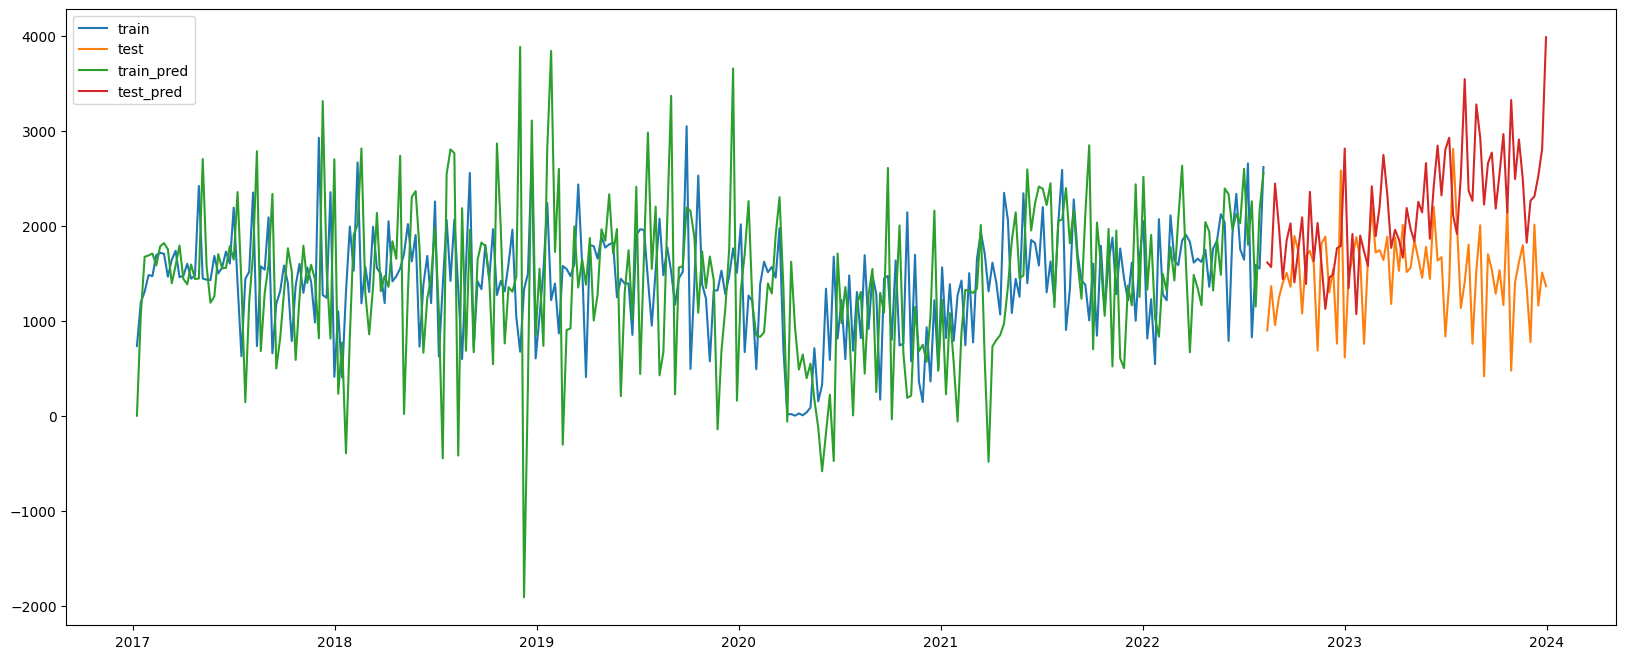

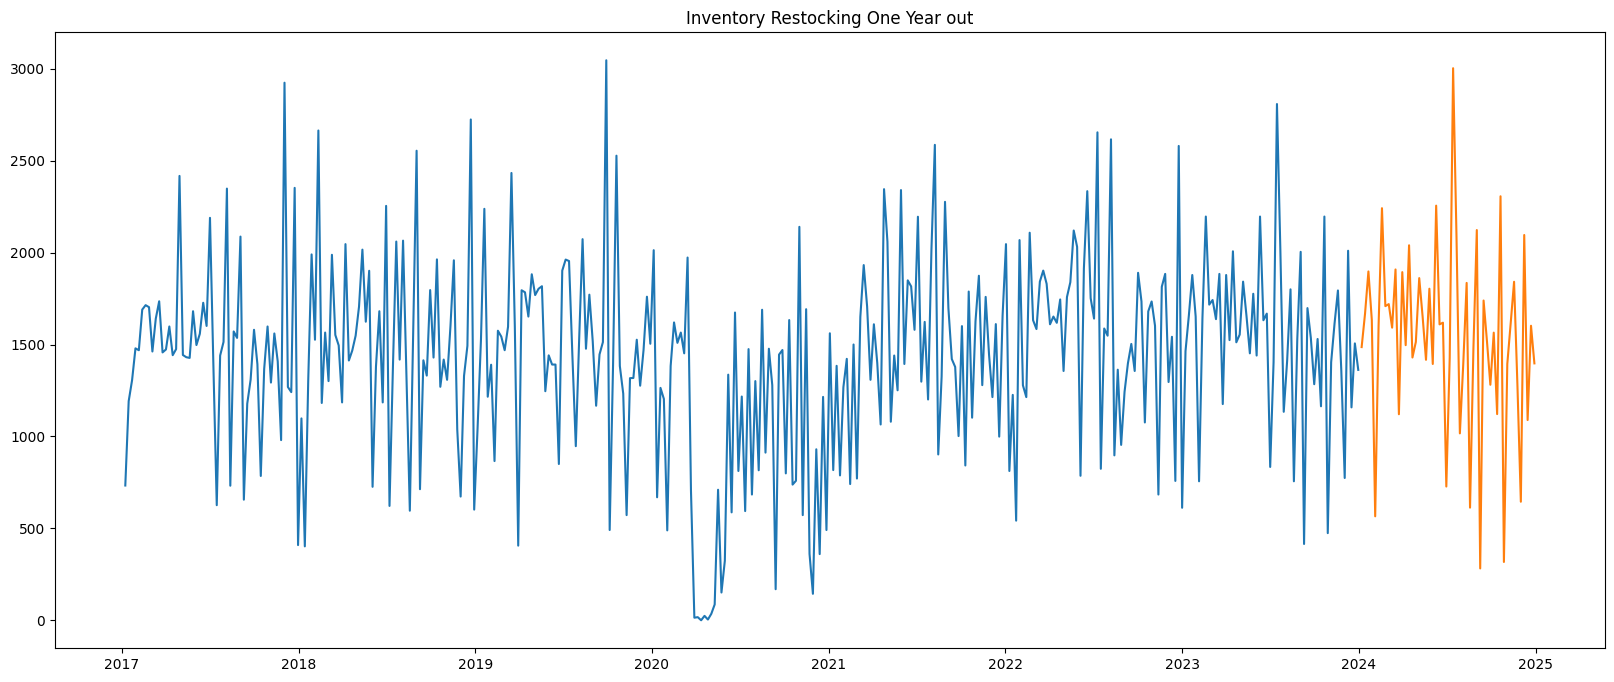

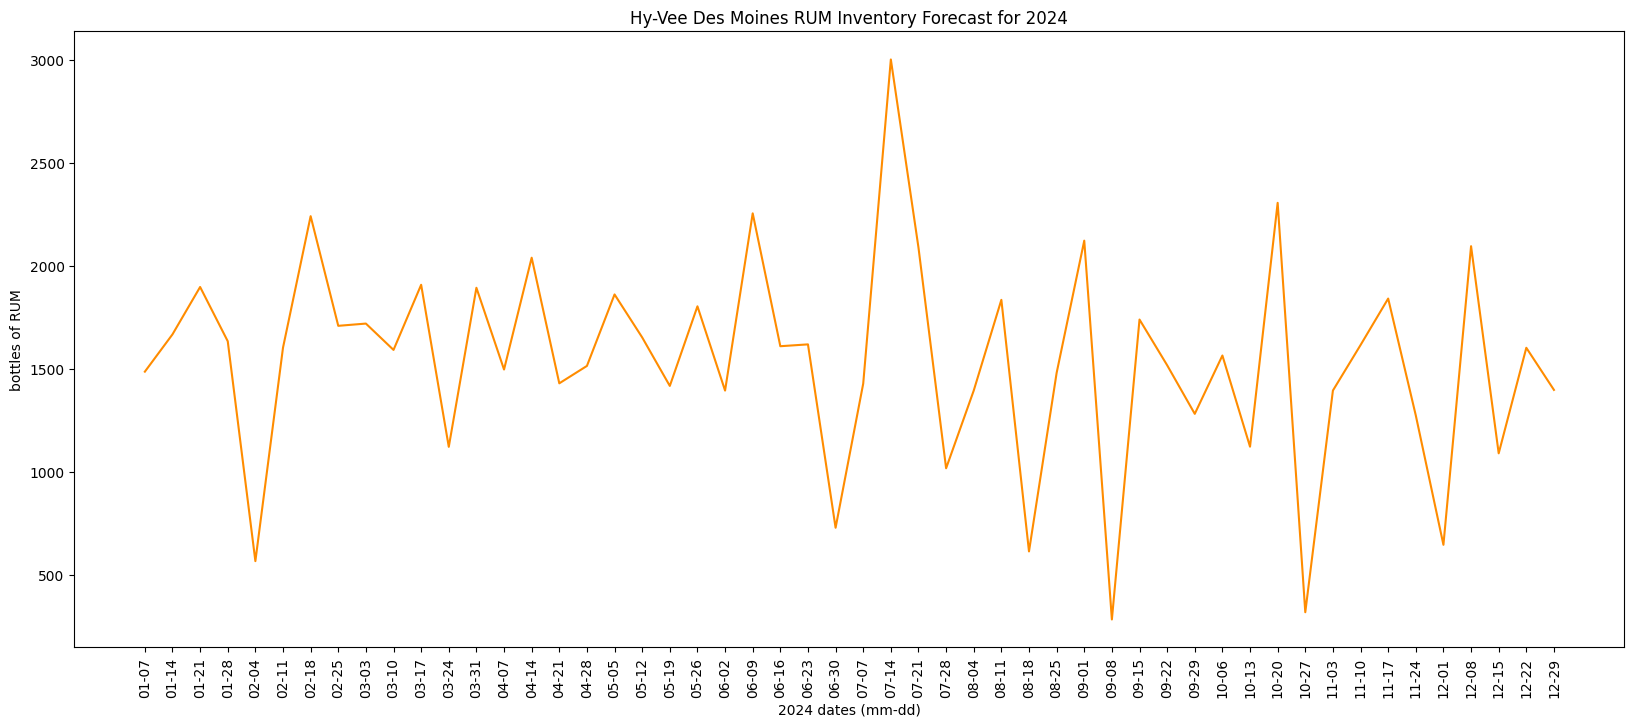

In [168]:
SARIMA_fit_and_forecast('RUM',1,2,2)

Great, we're getting the same results. Now let's run this Pipeline duo on other liquor store categories.

In [122]:
HVDM_preprocess_and_optimize_ARIMA('TEQUILA')

model with the lowest AIC score (score, then params_): (4558.98190127662, {'d': 2, 'p': 3, 'q': 2})
model with the lowest RMSE score (score, then params_): (729.678432127818, {'d': 1, 'p': 3, 'q': 1})


train set RMSE: 643.2912035409529
test set RMSE: 887.8283961267383


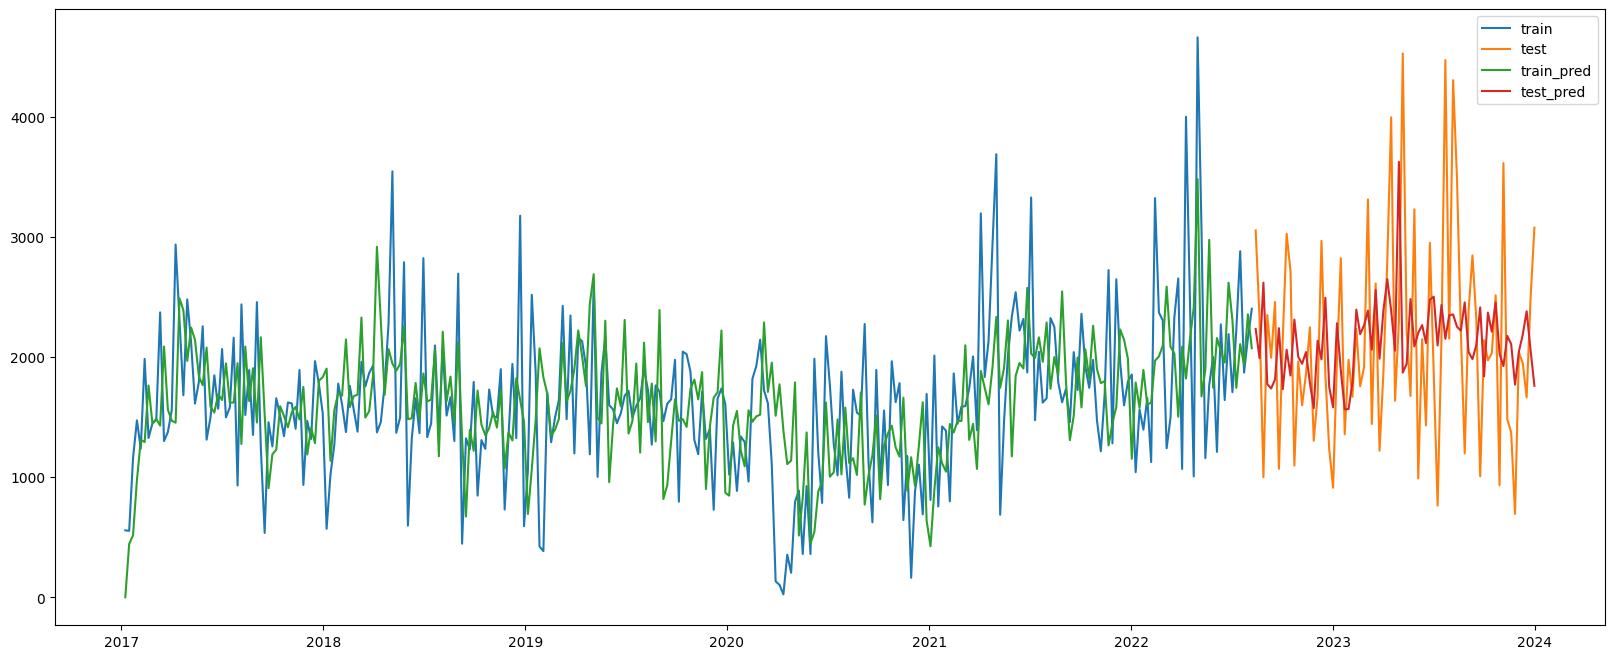

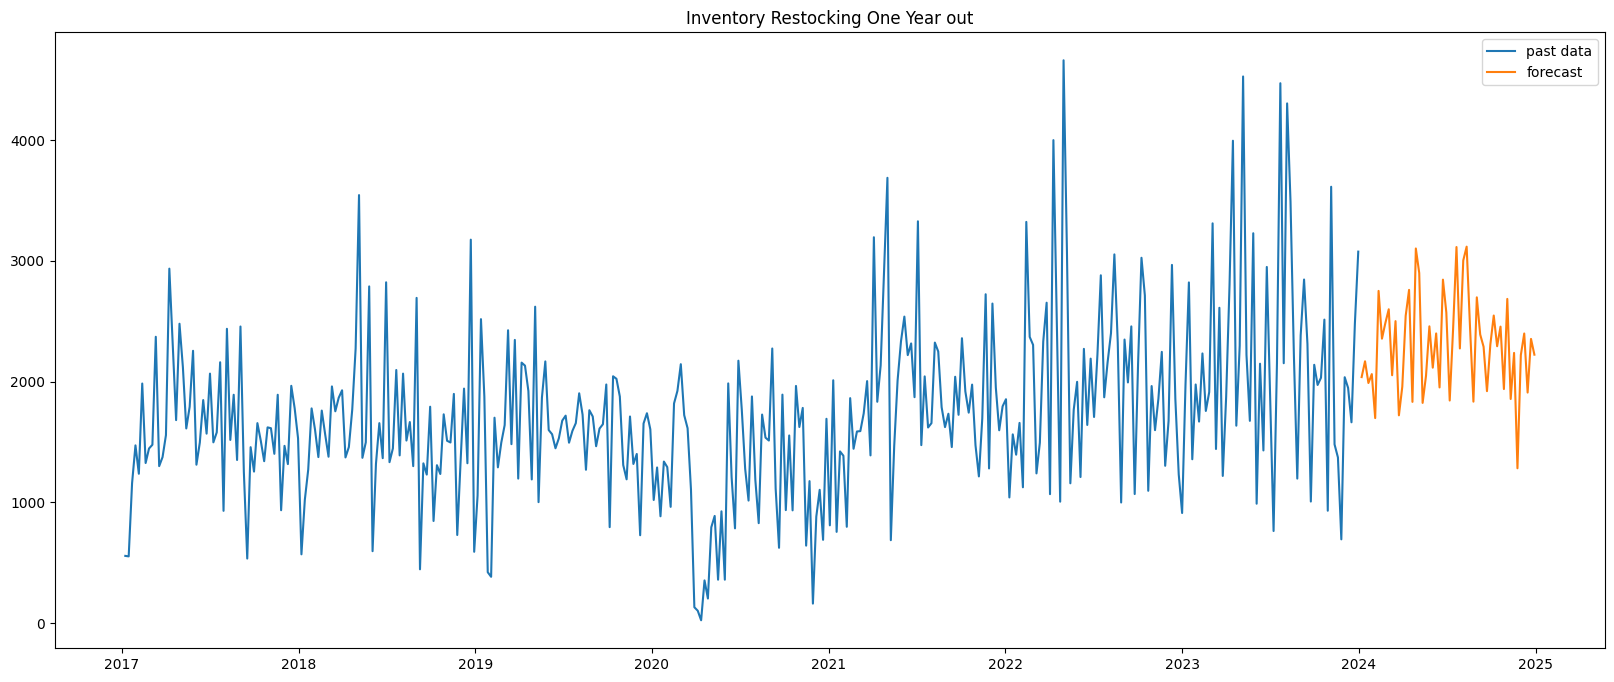

In [123]:
#Let's try the tequila model with the lowest RMSE this time to see whether the 'LU decomposition error' resurfaces
SARIMA_fit_and_forecast('TEQUILA',3,1,1)

Interestingly, this worked out well without any errors and did a better job than the AIC-oriented rum one.

Even though the rum SARIMA model threw an 'LU decomposition error', maybe we'll default to running the RMSE models unless they throw that error.

In [124]:
HVDM_preprocess_and_optimize_ARIMA('RUM')

model with the lowest AIC score (score, then params_): (4464.917013634473, {'d': 2, 'p': 1, 'q': 2})
model with the lowest RMSE score (score, then params_): (444.544027943803, {'d': 1, 'p': 2, 'q': 3})


In [126]:
#Double checking whether the rum SARIMA will throw the LU decomposition error
#SARIMA_fit_and_forecast('RUM', 2,1,3)

#...it did.